<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 458, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 458 (delta 7), reused 9 (delta 4), pack-reused 443 (from 1)
Receiving objects: 100% (458/458), 3.15 MiB | 6.48 MiB/s, done.
Resolving deltas: 100% (288/288), done.


In [2]:
from kltn.init.install_dependencies import install_packages
install_packages("./kltn")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import DiceLossWSigmoid, DiceLossWSoftmax
from kltn.models import unet3d, unet3d_cot, unet3d_cot_da, unet3d_rescot_da
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
log_path = "/content/drive/MyDrive/KLTN/logs"
source_folder = '/content/LITS17'
LOGGER = init_logger(log_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=source_folder)

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
0.00% complete (down: 0.0 kB/s up: 0.1 kB/s peers: 4) downloading LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
0.58% complete (down: 8359.4 kB/s up: 259.1 kB/s peers: 8) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreacha

## Load data

In [6]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=source_folder, seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [7]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [8]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 1, 128, 128, 128])


## Visual data

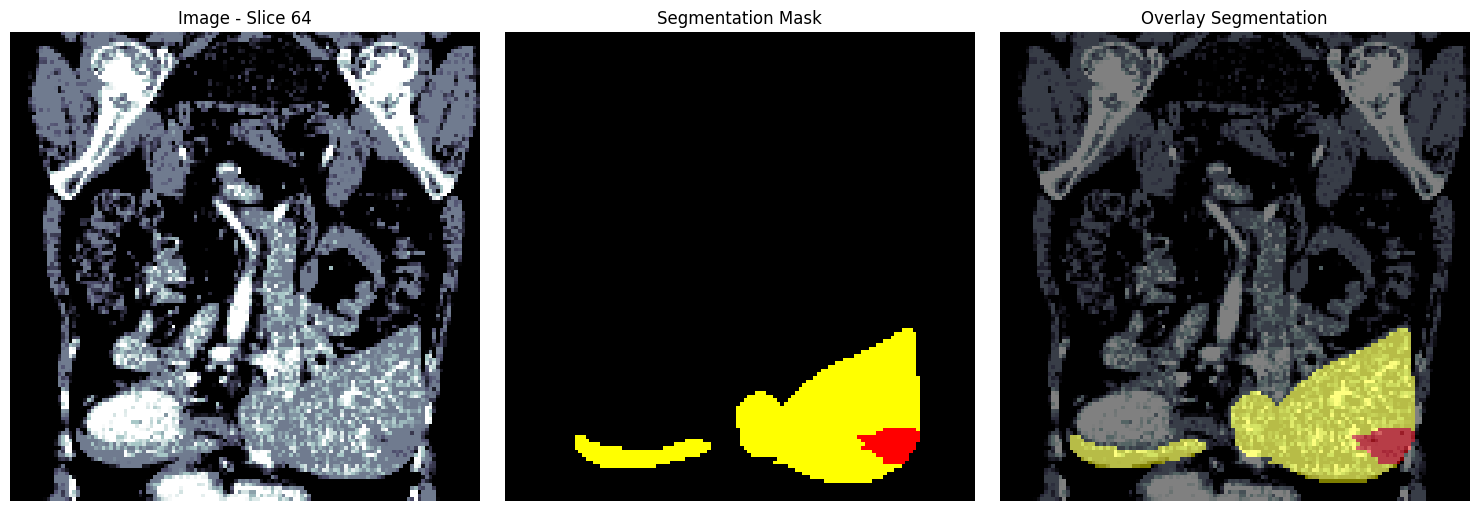

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 1, 128, 128, 128]

    slice_idx = image_sample.shape[2] // 2

    img_slice = image_sample[0, 0, slice_idx, :, :].numpy()
    label_slice = label_sample[0, 0, slice_idx, :, :].numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")


    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")


    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break

## Model

In [9]:
model = unet3d.UNet3D(in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 2512515


## Training

In [ ]:
start_epoch = 1
max_epochs = 50 # 100
batch_size = 1 # 2
val_every = 1

criterion = DiceLossWSoftmax().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
path_save_model = "/content/drive/MyDrive/KLTN/code/weight"

In [11]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(val_acc_max, best_epoch, dices_liver, dices_tumor, dices_avg, loss_epochs, trains_epoch
) = trainer(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer,
    loss_func = criterion,
    acc_func = dice_acc,
    scheduler = scheduler,
    batch_size = batch_size,
    max_epochs = max_epochs,
    start_epoch = start_epoch,
    val_every = val_every,
    path_save_model = path_save_model,
    logger = LOGGER,
    )

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/50 1/105 loss: 1.0143 time 15.58s
Epoch 1/50 2/105 loss: 0.9816 time 5.29s
Epoch 1/50 3/105 loss: 0.9574 time 0.90s
Epoch 1/50 4/105 loss: 0.9415 time 6.90s
Epoch 1/50 5/105 loss: 0.9291 time 5.87s
Epoch 1/50 6/105 loss: 0.9197 time 5.41s
Epoch 1/50 7/105 loss: 0.9124 time 1.78s
Epoch 1/50 8/105 loss: 0.9059 time 10.49s
Epoch 1/50 9/105 loss: 0.9003 time 4.00s
Epoch 1/50 10/105 loss: 0.8950 time 0.96s
Epoch 1/50 11/105 loss: 0.8886 time 1.20s
Epoch 1/50 12/105 loss: 0.8841 time 8.22s
Epoch 1/50 13/105 loss: 0.8782 time 1.37s
Epoch 1/50 14/105 loss: 0.8751 time 4.68s
Epoch 1/50 15/105 loss: 0.8710 time 2.35s
Epoch 1/50 16/105 loss: 0.8679 time 16.37s
Epoch 1/50 17/105 loss: 0.8636 time 1.54s
Epoch 1/50 18/105 loss: 0.8592 time 1.33s
Epoch 1/50 19/105 loss: 0.8561 time 7.92s
Epoch 1/50 20/105 loss: 0.8533 time 2.60s
Epoch 1/50 21/105 loss: 0.8508 time 9.08s
Epoch 1/50 22/105 loss: 0.8480 time 10.59s
Epoch 1/50 23/105 loss: 0.8445 time 1.25s
Epoch 1/50 24/105 loss: 0.8421 time 9.8

Final training epochs: 1/50 ---[loss: 0.6918] ---[time 622.53s]
INFO:kltn.utils.logger:Final training epochs: 1/50 ---[loss: 0.6918] ---[time 622.53s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/50 105/105 loss: 0.6918 time 12.22s


/content/kltn/utils/metrics.py:139: RuntimeWarning: invalid value encountered in divide
  self.avg = self.sum / self.count
Val 1/50 1/26, Dice_Liver: 0.814614, Dice_Tumor: nan, Dice_Avg: nan, time 3.82s
INFO:kltn.utils.logger:Val 1/50 1/26, Dice_Liver: 0.814614, Dice_Tumor: nan, Dice_Avg: nan, time 3.82s
Val 1/50 2/26, Dice_Liver: 0.834558, Dice_Tumor: 0.000000, Dice_Avg: 0.417279, time 5.41s
INFO:kltn.utils.logger:Val 1/50 2/26, Dice_Liver: 0.834558, Dice_Tumor: 0.000000, Dice_Avg: 0.417279, time 5.41s
Val 1/50 3/26, Dice_Liver: 0.742386, Dice_Tumor: 0.000000, Dice_Avg: 0.371193, time 2.00s
INFO:kltn.utils.logger:Val 1/50 3/26, Dice_Liver: 0.742386, Dice_Tumor: 0.000000, Dice_Avg: 0.371193, time 2.00s
Val 1/50 4/26, Dice_Liver: 0.730497, Dice_Tumor: 0.000000, Dice_Avg: 0.365249, time 9.18s
INFO:kltn.utils.logger:Val 1/50 4/26, Dice_Liver: 0.730497, Dice_Tumor: 0.000000, Dice_Avg: 0.365249, time 9.18s
Val 1/50 5/26, Dice_Liver: 0.748637, Dice_Tumor: 0.000000, Dice_Avg: 0.374318, time 6

New best (0.000000 --> 0.357588). At epoch 1



==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/50 1/105 loss: 0.5294 time 9.90s
Epoch 2/50 2/105 loss: 0.5415 time 1.77s
Epoch 2/50 3/105 loss: 0.5400 time 9.34s
Epoch 2/50 4/105 loss: 0.5406 time 1.31s
Epoch 2/50 5/105 loss: 0.5413 time 7.37s
Epoch 2/50 6/105 loss: 0.5420 time 2.79s
Epoch 2/50 7/105 loss: 0.5419 time 2.38s
Epoch 2/50 8/105 loss: 0.5402 time 6.52s
Epoch 2/50 9/105 loss: 0.5399 time 12.42s
Epoch 2/50 10/105 loss: 0.5365 time 1.51s
Epoch 2/50 11/105 loss: 0.5362 time 2.80s
Epoch 2/50 12/105 loss: 0.5339 time 7.43s
Epoch 2/50 13/105 loss: 0.5337 time 12.83s
Epoch 2/50 14/105 loss: 0.5329 time 13.31s
Epoch 2/50 15/105 loss: 0.5322 time 7.56s
Epoch 2/50 16/105 loss: 0.5308 time 4.00s
Epoch 2/50 17/105 loss: 0.5297 time 10.02s
Epoch 2/50 18/105 loss: 0.5286 time 2.04s
Epoch 2/50 19/105 loss: 0.5275 time 7.78s
Epoch 2/50 20/105 loss: 0.5268 time 10.55s
Epoch 2/50 21/105 loss: 0.5257 time 6.60s
Epoch 2/50 22/105 loss: 0.5246 time 5.44s
Epoch 2/50 23/105 loss: 0.5237 time 4.35s
Epoch 2/50 24/105 loss: 0.5230 time 6.

Final training epochs: 2/50 ---[loss: 0.4666] ---[time 633.26s]
INFO:kltn.utils.logger:Final training epochs: 2/50 ---[loss: 0.4666] ---[time 633.26s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/50 105/105 loss: 0.4666 time 0.86s


Val 2/50 1/26, Dice_Liver: 0.816305, Dice_Tumor: nan, Dice_Avg: nan, time 1.89s
INFO:kltn.utils.logger:Val 2/50 1/26, Dice_Liver: 0.816305, Dice_Tumor: nan, Dice_Avg: nan, time 1.89s
Val 2/50 2/26, Dice_Liver: 0.836451, Dice_Tumor: 0.000000, Dice_Avg: 0.418225, time 8.21s
INFO:kltn.utils.logger:Val 2/50 2/26, Dice_Liver: 0.836451, Dice_Tumor: 0.000000, Dice_Avg: 0.418225, time 8.21s
Val 2/50 3/26, Dice_Liver: 0.817899, Dice_Tumor: 0.000000, Dice_Avg: 0.408950, time 2.39s
INFO:kltn.utils.logger:Val 2/50 3/26, Dice_Liver: 0.817899, Dice_Tumor: 0.000000, Dice_Avg: 0.408950, time 2.39s
Val 2/50 4/26, Dice_Liver: 0.782196, Dice_Tumor: 0.000000, Dice_Avg: 0.391098, time 9.26s
INFO:kltn.utils.logger:Val 2/50 4/26, Dice_Liver: 0.782196, Dice_Tumor: 0.000000, Dice_Avg: 0.391098, time 9.26s
Val 2/50 5/26, Dice_Liver: 0.788088, Dice_Tumor: 0.000000, Dice_Avg: 0.394044, time 7.05s
INFO:kltn.utils.logger:Val 2/50 5/26, Dice_Liver: 0.788088, Dice_Tumor: 0.000000, Dice_Avg: 0.394044, time 7.05s
Val 2

New best (0.357588 --> 0.374770). At epoch 2
Epoch 3/50 1/105 loss: 0.4242 time 2.37s
Epoch 3/50 2/105 loss: 0.4052 time 6.76s
Epoch 3/50 3/105 loss: 0.3981 time 1.88s
Epoch 3/50 4/105 loss: 0.4013 time 2.36s
Epoch 3/50 5/105 loss: 0.3993 time 2.63s
Epoch 3/50 6/105 loss: 0.3980 time 11.66s
Epoch 3/50 7/105 loss: 0.3949 time 7.19s
Epoch 3/50 8/105 loss: 0.3930 time 6.00s
Epoch 3/50 9/105 loss: 0.3916 time 2.56s
Epoch 3/50 10/105 loss: 0.3922 time 11.50s
Epoch 3/50 11/105 loss: 0.3913 time 11.16s
Epoch 3/50 12/105 loss: 0.3890 time 3.24s
Epoch 3/50 13/105 loss: 0.3884 time 8.68s
Epoch 3/50 14/105 loss: 0.3882 time 10.53s
Epoch 3/50 15/105 loss: 0.3893 time 2.63s
Epoch 3/50 16/105 loss: 0.3890 time 12.68s
Epoch 3/50 17/105 loss: 0.3898 time 2.87s
Epoch 3/50 18/105 loss: 0.3889 time 9.07s
Epoch 3/50 19/105 loss: 0.3878 time 4.19s
Epoch 3/50 20/105 loss: 0.3862 time 1.87s
Epoch 3/50 21/105 loss: 0.3848 time 8.25s
Epoch 3/50 22/105 loss: 0.3855 time 1.53s
Epoch 3/50 23/105 loss: 0.3842 time

Final training epochs: 3/50 ---[loss: 0.3607] ---[time 641.99s]
INFO:kltn.utils.logger:Final training epochs: 3/50 ---[loss: 0.3607] ---[time 641.99s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/50 105/105 loss: 0.3607 time 8.30s


Val 3/50 1/26, Dice_Liver: 0.785294, Dice_Tumor: nan, Dice_Avg: nan, time 1.61s
INFO:kltn.utils.logger:Val 3/50 1/26, Dice_Liver: 0.785294, Dice_Tumor: nan, Dice_Avg: nan, time 1.61s
Val 3/50 2/26, Dice_Liver: 0.817327, Dice_Tumor: 0.000000, Dice_Avg: 0.408664, time 6.71s
INFO:kltn.utils.logger:Val 3/50 2/26, Dice_Liver: 0.817327, Dice_Tumor: 0.000000, Dice_Avg: 0.408664, time 6.71s
Val 3/50 3/26, Dice_Liver: 0.807820, Dice_Tumor: 0.000000, Dice_Avg: 0.403910, time 2.62s
INFO:kltn.utils.logger:Val 3/50 3/26, Dice_Liver: 0.807820, Dice_Tumor: 0.000000, Dice_Avg: 0.403910, time 2.62s
Val 3/50 4/26, Dice_Liver: 0.800912, Dice_Tumor: 0.000000, Dice_Avg: 0.400456, time 8.94s
INFO:kltn.utils.logger:Val 3/50 4/26, Dice_Liver: 0.800912, Dice_Tumor: 0.000000, Dice_Avg: 0.400456, time 8.94s
Val 3/50 5/26, Dice_Liver: 0.808258, Dice_Tumor: 0.000000, Dice_Avg: 0.404129, time 6.91s
INFO:kltn.utils.logger:Val 3/50 5/26, Dice_Liver: 0.808258, Dice_Tumor: 0.000000, Dice_Avg: 0.404129, time 6.91s
Val 3

New best (0.374770 --> 0.387684). At epoch 3
Epoch 4/50 1/105 loss: 0.3249 time 12.54s
Epoch 4/50 2/105 loss: 0.3331 time 6.12s
Epoch 4/50 3/105 loss: 0.3529 time 1.90s
Epoch 4/50 4/105 loss: 0.3501 time 3.65s
Epoch 4/50 5/105 loss: 0.3461 time 7.79s
Epoch 4/50 6/105 loss: 0.3441 time 11.35s
Epoch 4/50 7/105 loss: 0.3451 time 10.55s
Epoch 4/50 8/105 loss: 0.3441 time 7.63s
Epoch 4/50 9/105 loss: 0.3421 time 6.62s
Epoch 4/50 10/105 loss: 0.3396 time 2.17s
Epoch 4/50 11/105 loss: 0.3397 time 1.72s
Epoch 4/50 12/105 loss: 0.3388 time 4.05s
Epoch 4/50 13/105 loss: 0.3374 time 12.20s
Epoch 4/50 14/105 loss: 0.3359 time 11.17s
Epoch 4/50 15/105 loss: 0.3346 time 7.45s
Epoch 4/50 16/105 loss: 0.3350 time 4.79s
Epoch 4/50 17/105 loss: 0.3354 time 1.87s
Epoch 4/50 18/105 loss: 0.3346 time 2.39s
Epoch 4/50 19/105 loss: 0.3373 time 1.23s
Epoch 4/50 20/105 loss: 0.3377 time 5.02s
Epoch 4/50 21/105 loss: 0.3374 time 7.55s
Epoch 4/50 22/105 loss: 0.3365 time 12.45s
Epoch 4/50 23/105 loss: 0.3368 tim

Final training epochs: 4/50 ---[loss: 0.3242] ---[time 635.37s]
INFO:kltn.utils.logger:Final training epochs: 4/50 ---[loss: 0.3242] ---[time 635.37s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/50 105/105 loss: 0.3242 time 2.30s


Val 4/50 1/26, Dice_Liver: 0.843746, Dice_Tumor: nan, Dice_Avg: nan, time 1.50s
INFO:kltn.utils.logger:Val 4/50 1/26, Dice_Liver: 0.843746, Dice_Tumor: nan, Dice_Avg: nan, time 1.50s
Val 4/50 2/26, Dice_Liver: 0.849691, Dice_Tumor: 0.000000, Dice_Avg: 0.424845, time 6.86s
INFO:kltn.utils.logger:Val 4/50 2/26, Dice_Liver: 0.849691, Dice_Tumor: 0.000000, Dice_Avg: 0.424845, time 6.86s
Val 4/50 3/26, Dice_Liver: 0.849901, Dice_Tumor: 0.000000, Dice_Avg: 0.424951, time 2.58s
INFO:kltn.utils.logger:Val 4/50 3/26, Dice_Liver: 0.849901, Dice_Tumor: 0.000000, Dice_Avg: 0.424951, time 2.58s
Val 4/50 4/26, Dice_Liver: 0.854358, Dice_Tumor: 0.000000, Dice_Avg: 0.427179, time 9.01s
INFO:kltn.utils.logger:Val 4/50 4/26, Dice_Liver: 0.854358, Dice_Tumor: 0.000000, Dice_Avg: 0.427179, time 9.01s
Val 4/50 5/26, Dice_Liver: 0.862690, Dice_Tumor: 0.000000, Dice_Avg: 0.431345, time 7.20s
INFO:kltn.utils.logger:Val 4/50 5/26, Dice_Liver: 0.862690, Dice_Tumor: 0.000000, Dice_Avg: 0.431345, time 7.20s
Val 4

New best (0.387684 --> 0.413631). At epoch 4
Epoch 5/50 1/105 loss: 0.3057 time 9.41s
Epoch 5/50 2/105 loss: 0.3212 time 1.39s
Epoch 5/50 3/105 loss: 0.3138 time 5.88s
Epoch 5/50 4/105 loss: 0.3118 time 8.71s
Epoch 5/50 5/105 loss: 0.3165 time 9.03s
Epoch 5/50 6/105 loss: 0.3149 time 5.95s
Epoch 5/50 7/105 loss: 0.3116 time 6.92s
Epoch 5/50 8/105 loss: 0.3102 time 1.03s
Epoch 5/50 9/105 loss: 0.3124 time 2.26s
Epoch 5/50 10/105 loss: 0.3118 time 1.91s
Epoch 5/50 11/105 loss: 0.3109 time 11.74s
Epoch 5/50 12/105 loss: 0.3092 time 6.59s
Epoch 5/50 13/105 loss: 0.3094 time 2.29s
Epoch 5/50 14/105 loss: 0.3112 time 1.49s
Epoch 5/50 15/105 loss: 0.3119 time 6.75s
Epoch 5/50 16/105 loss: 0.3109 time 7.15s
Epoch 5/50 17/105 loss: 0.3137 time 13.54s
Epoch 5/50 18/105 loss: 0.3138 time 7.58s
Epoch 5/50 19/105 loss: 0.3146 time 1.46s
Epoch 5/50 20/105 loss: 0.3145 time 6.97s
Epoch 5/50 21/105 loss: 0.3144 time 5.27s
Epoch 5/50 22/105 loss: 0.3168 time 1.36s
Epoch 5/50 23/105 loss: 0.3158 time 1.

Final training epochs: 5/50 ---[loss: 0.3108] ---[time 638.66s]
INFO:kltn.utils.logger:Final training epochs: 5/50 ---[loss: 0.3108] ---[time 638.66s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/50 105/105 loss: 0.3108 time 7.09s


Val 5/50 1/26, Dice_Liver: 0.851878, Dice_Tumor: nan, Dice_Avg: nan, time 1.58s
INFO:kltn.utils.logger:Val 5/50 1/26, Dice_Liver: 0.851878, Dice_Tumor: nan, Dice_Avg: nan, time 1.58s
Val 5/50 2/26, Dice_Liver: 0.876549, Dice_Tumor: 0.000000, Dice_Avg: 0.438275, time 7.57s
INFO:kltn.utils.logger:Val 5/50 2/26, Dice_Liver: 0.876549, Dice_Tumor: 0.000000, Dice_Avg: 0.438275, time 7.57s
Val 5/50 3/26, Dice_Liver: 0.873690, Dice_Tumor: 0.000000, Dice_Avg: 0.436845, time 2.73s
INFO:kltn.utils.logger:Val 5/50 3/26, Dice_Liver: 0.873690, Dice_Tumor: 0.000000, Dice_Avg: 0.436845, time 2.73s
Val 5/50 4/26, Dice_Liver: 0.860834, Dice_Tumor: 0.000000, Dice_Avg: 0.430417, time 8.96s
INFO:kltn.utils.logger:Val 5/50 4/26, Dice_Liver: 0.860834, Dice_Tumor: 0.000000, Dice_Avg: 0.430417, time 8.96s
Val 5/50 5/26, Dice_Liver: 0.865072, Dice_Tumor: 0.000000, Dice_Avg: 0.432536, time 6.71s
INFO:kltn.utils.logger:Val 5/50 5/26, Dice_Liver: 0.865072, Dice_Tumor: 0.000000, Dice_Avg: 0.432536, time 6.71s
Val 5

Epoch 6/50 1/105 loss: 0.3271 time 2.98s
Epoch 6/50 2/105 loss: 0.3137 time 6.63s
Epoch 6/50 3/105 loss: 0.3155 time 1.36s
Epoch 6/50 4/105 loss: 0.3181 time 7.27s
Epoch 6/50 5/105 loss: 0.3143 time 3.00s
Epoch 6/50 6/105 loss: 0.3090 time 12.19s
Epoch 6/50 7/105 loss: 0.3079 time 5.42s
Epoch 6/50 8/105 loss: 0.3098 time 4.09s
Epoch 6/50 9/105 loss: 0.3090 time 11.09s
Epoch 6/50 10/105 loss: 0.3151 time 1.39s
Epoch 6/50 11/105 loss: 0.3133 time 2.89s
Epoch 6/50 12/105 loss: 0.3111 time 1.91s
Epoch 6/50 13/105 loss: 0.3100 time 9.76s
Epoch 6/50 14/105 loss: 0.3091 time 3.58s
Epoch 6/50 15/105 loss: 0.3078 time 7.67s
Epoch 6/50 16/105 loss: 0.3076 time 9.18s
Epoch 6/50 17/105 loss: 0.3068 time 10.31s
Epoch 6/50 18/105 loss: 0.3085 time 1.32s
Epoch 6/50 19/105 loss: 0.3099 time 2.45s
Epoch 6/50 20/105 loss: 0.3089 time 12.41s
Epoch 6/50 21/105 loss: 0.3074 time 14.13s
Epoch 6/50 22/105 loss: 0.3071 time 7.97s
Epoch 6/50 23/105 loss: 0.3062 time 0.95s
Epoch 6/50 24/105 loss: 0.3059 time 7.

Final training epochs: 6/50 ---[loss: 0.3072] ---[time 639.43s]
INFO:kltn.utils.logger:Final training epochs: 6/50 ---[loss: 0.3072] ---[time 639.43s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/50 105/105 loss: 0.3072 time 10.34s


Val 6/50 1/26, Dice_Liver: 0.869595, Dice_Tumor: nan, Dice_Avg: nan, time 1.57s
INFO:kltn.utils.logger:Val 6/50 1/26, Dice_Liver: 0.869595, Dice_Tumor: nan, Dice_Avg: nan, time 1.57s
Val 6/50 2/26, Dice_Liver: 0.868712, Dice_Tumor: 0.000000, Dice_Avg: 0.434356, time 6.88s
INFO:kltn.utils.logger:Val 6/50 2/26, Dice_Liver: 0.868712, Dice_Tumor: 0.000000, Dice_Avg: 0.434356, time 6.88s
Val 6/50 3/26, Dice_Liver: 0.871153, Dice_Tumor: 0.000000, Dice_Avg: 0.435576, time 2.14s
INFO:kltn.utils.logger:Val 6/50 3/26, Dice_Liver: 0.871153, Dice_Tumor: 0.000000, Dice_Avg: 0.435576, time 2.14s
Val 6/50 4/26, Dice_Liver: 0.869928, Dice_Tumor: 0.000000, Dice_Avg: 0.434964, time 9.15s
INFO:kltn.utils.logger:Val 6/50 4/26, Dice_Liver: 0.869928, Dice_Tumor: 0.000000, Dice_Avg: 0.434964, time 9.15s
Val 6/50 5/26, Dice_Liver: 0.877359, Dice_Tumor: 0.000000, Dice_Avg: 0.438679, time 6.61s
INFO:kltn.utils.logger:Val 6/50 5/26, Dice_Liver: 0.877359, Dice_Tumor: 0.000000, Dice_Avg: 0.438679, time 6.61s
Val 6

New best (0.413631 --> 0.418619). At epoch 6
Epoch 7/50 1/105 loss: 0.2992 time 8.64s
Epoch 7/50 2/105 loss: 0.2995 time 4.69s
Epoch 7/50 3/105 loss: 0.3011 time 1.62s
Epoch 7/50 4/105 loss: 0.2976 time 1.94s
Epoch 7/50 5/105 loss: 0.3069 time 2.96s
Epoch 7/50 6/105 loss: 0.3034 time 13.02s
Epoch 7/50 7/105 loss: 0.3036 time 7.00s
Epoch 7/50 8/105 loss: 0.3059 time 11.28s
Epoch 7/50 9/105 loss: 0.3057 time 2.56s
Epoch 7/50 10/105 loss: 0.3041 time 5.88s
Epoch 7/50 11/105 loss: 0.3035 time 2.00s
Epoch 7/50 12/105 loss: 0.3046 time 6.13s
Epoch 7/50 13/105 loss: 0.3042 time 4.90s
Epoch 7/50 14/105 loss: 0.3039 time 2.28s
Epoch 7/50 15/105 loss: 0.3028 time 12.71s
Epoch 7/50 16/105 loss: 0.3019 time 8.91s
Epoch 7/50 17/105 loss: 0.3015 time 9.06s
Epoch 7/50 18/105 loss: 0.3008 time 8.43s
Epoch 7/50 19/105 loss: 0.3021 time 1.31s
Epoch 7/50 20/105 loss: 0.3022 time 2.58s
Epoch 7/50 21/105 loss: 0.3024 time 11.12s
Epoch 7/50 22/105 loss: 0.3016 time 3.79s
Epoch 7/50 23/105 loss: 0.3015 time 

Final training epochs: 7/50 ---[loss: 0.3032] ---[time 639.05s]
INFO:kltn.utils.logger:Final training epochs: 7/50 ---[loss: 0.3032] ---[time 639.05s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/50 105/105 loss: 0.3032 time 4.48s


Val 7/50 1/26, Dice_Liver: 0.871180, Dice_Tumor: nan, Dice_Avg: nan, time 1.59s
INFO:kltn.utils.logger:Val 7/50 1/26, Dice_Liver: 0.871180, Dice_Tumor: nan, Dice_Avg: nan, time 1.59s
Val 7/50 2/26, Dice_Liver: 0.874585, Dice_Tumor: 0.000000, Dice_Avg: 0.437292, time 8.13s
INFO:kltn.utils.logger:Val 7/50 2/26, Dice_Liver: 0.874585, Dice_Tumor: 0.000000, Dice_Avg: 0.437292, time 8.13s
Val 7/50 3/26, Dice_Liver: 0.872782, Dice_Tumor: 0.000000, Dice_Avg: 0.436391, time 2.13s
INFO:kltn.utils.logger:Val 7/50 3/26, Dice_Liver: 0.872782, Dice_Tumor: 0.000000, Dice_Avg: 0.436391, time 2.13s
Val 7/50 4/26, Dice_Liver: 0.859837, Dice_Tumor: 0.000000, Dice_Avg: 0.429918, time 8.99s
INFO:kltn.utils.logger:Val 7/50 4/26, Dice_Liver: 0.859837, Dice_Tumor: 0.000000, Dice_Avg: 0.429918, time 8.99s
Val 7/50 5/26, Dice_Liver: 0.863598, Dice_Tumor: 0.000000, Dice_Avg: 0.431799, time 6.44s
INFO:kltn.utils.logger:Val 7/50 5/26, Dice_Liver: 0.863598, Dice_Tumor: 0.000000, Dice_Avg: 0.431799, time 6.44s
Val 7

Epoch 8/50 1/105 loss: 0.3318 time 5.11s
Epoch 8/50 2/105 loss: 0.3088 time 9.16s
Epoch 8/50 3/105 loss: 0.3036 time 2.66s
Epoch 8/50 4/105 loss: 0.3008 time 9.07s
Epoch 8/50 5/105 loss: 0.2984 time 9.71s
Epoch 8/50 6/105 loss: 0.3004 time 2.48s
Epoch 8/50 7/105 loss: 0.3000 time 2.38s
Epoch 8/50 8/105 loss: 0.3004 time 11.35s
Epoch 8/50 9/105 loss: 0.3004 time 2.11s
Epoch 8/50 10/105 loss: 0.3018 time 1.31s
Epoch 8/50 11/105 loss: 0.3005 time 2.67s
Epoch 8/50 12/105 loss: 0.3005 time 8.35s
Epoch 8/50 13/105 loss: 0.2999 time 6.27s
Epoch 8/50 14/105 loss: 0.2994 time 0.95s
Epoch 8/50 15/105 loss: 0.3003 time 3.02s
Epoch 8/50 16/105 loss: 0.3011 time 12.32s
Epoch 8/50 17/105 loss: 0.3004 time 3.62s
Epoch 8/50 18/105 loss: 0.3009 time 1.19s
Epoch 8/50 19/105 loss: 0.3015 time 2.82s
Epoch 8/50 20/105 loss: 0.3029 time 7.14s
Epoch 8/50 21/105 loss: 0.3021 time 0.99s
Epoch 8/50 22/105 loss: 0.3018 time 11.06s
Epoch 8/50 23/105 loss: 0.3022 time 1.21s
Epoch 8/50 24/105 loss: 0.3022 time 1.81

Final training epochs: 8/50 ---[loss: 0.3012] ---[time 636.64s]
INFO:kltn.utils.logger:Final training epochs: 8/50 ---[loss: 0.3012] ---[time 636.64s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/50 105/105 loss: 0.3012 time 8.01s


Val 8/50 1/26, Dice_Liver: 0.870340, Dice_Tumor: nan, Dice_Avg: nan, time 1.61s
INFO:kltn.utils.logger:Val 8/50 1/26, Dice_Liver: 0.870340, Dice_Tumor: nan, Dice_Avg: nan, time 1.61s
Val 8/50 2/26, Dice_Liver: 0.881840, Dice_Tumor: 0.000000, Dice_Avg: 0.440920, time 7.79s
INFO:kltn.utils.logger:Val 8/50 2/26, Dice_Liver: 0.881840, Dice_Tumor: 0.000000, Dice_Avg: 0.440920, time 7.79s
Val 8/50 3/26, Dice_Liver: 0.878714, Dice_Tumor: 0.000000, Dice_Avg: 0.439357, time 2.52s
INFO:kltn.utils.logger:Val 8/50 3/26, Dice_Liver: 0.878714, Dice_Tumor: 0.000000, Dice_Avg: 0.439357, time 2.52s
Val 8/50 4/26, Dice_Liver: 0.877619, Dice_Tumor: 0.000000, Dice_Avg: 0.438809, time 8.82s
INFO:kltn.utils.logger:Val 8/50 4/26, Dice_Liver: 0.877619, Dice_Tumor: 0.000000, Dice_Avg: 0.438809, time 8.82s
Val 8/50 5/26, Dice_Liver: 0.884834, Dice_Tumor: 0.000000, Dice_Avg: 0.442417, time 6.84s
INFO:kltn.utils.logger:Val 8/50 5/26, Dice_Liver: 0.884834, Dice_Tumor: 0.000000, Dice_Avg: 0.442417, time 6.84s
Val 8

New best (0.418619 --> 0.418979). At epoch 8
Epoch 9/50 1/105 loss: 0.2875 time 2.93s
Epoch 9/50 2/105 loss: 0.2889 time 12.05s
Epoch 9/50 3/105 loss: 0.2990 time 10.84s
Epoch 9/50 4/105 loss: 0.2887 time 6.63s
Epoch 9/50 5/105 loss: 0.2889 time 2.43s
Epoch 9/50 6/105 loss: 0.2987 time 1.40s
Epoch 9/50 7/105 loss: 0.2969 time 9.21s
Epoch 9/50 8/105 loss: 0.3021 time 1.57s
Epoch 9/50 9/105 loss: 0.3024 time 9.19s
Epoch 9/50 10/105 loss: 0.3025 time 1.01s
Epoch 9/50 11/105 loss: 0.3009 time 8.54s
Epoch 9/50 12/105 loss: 0.3005 time 2.22s
Epoch 9/50 13/105 loss: 0.3027 time 1.38s
Epoch 9/50 14/105 loss: 0.3022 time 7.48s
Epoch 9/50 15/105 loss: 0.3018 time 5.29s
Epoch 9/50 16/105 loss: 0.3006 time 7.60s
Epoch 9/50 17/105 loss: 0.3002 time 6.60s
Epoch 9/50 18/105 loss: 0.3012 time 7.19s
Epoch 9/50 19/105 loss: 0.3009 time 10.04s
Epoch 9/50 20/105 loss: 0.3008 time 4.19s
Epoch 9/50 21/105 loss: 0.2999 time 9.65s
Epoch 9/50 22/105 loss: 0.2993 time 7.63s
Epoch 9/50 23/105 loss: 0.2993 time 2

Final training epochs: 9/50 ---[loss: 0.3007] ---[time 635.11s]
INFO:kltn.utils.logger:Final training epochs: 9/50 ---[loss: 0.3007] ---[time 635.11s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/50 105/105 loss: 0.3007 time 1.79s


Val 9/50 1/26, Dice_Liver: 0.886173, Dice_Tumor: nan, Dice_Avg: nan, time 1.57s
INFO:kltn.utils.logger:Val 9/50 1/26, Dice_Liver: 0.886173, Dice_Tumor: nan, Dice_Avg: nan, time 1.57s
Val 9/50 2/26, Dice_Liver: 0.890059, Dice_Tumor: 0.018634, Dice_Avg: 0.454346, time 7.91s
INFO:kltn.utils.logger:Val 9/50 2/26, Dice_Liver: 0.890059, Dice_Tumor: 0.018634, Dice_Avg: 0.454346, time 7.91s
Val 9/50 3/26, Dice_Liver: 0.888032, Dice_Tumor: 0.009317, Dice_Avg: 0.448674, time 2.13s
INFO:kltn.utils.logger:Val 9/50 3/26, Dice_Liver: 0.888032, Dice_Tumor: 0.009317, Dice_Avg: 0.448674, time 2.13s
Val 9/50 4/26, Dice_Liver: 0.882773, Dice_Tumor: 0.031691, Dice_Avg: 0.457232, time 9.78s
INFO:kltn.utils.logger:Val 9/50 4/26, Dice_Liver: 0.882773, Dice_Tumor: 0.031691, Dice_Avg: 0.457232, time 9.78s
Val 9/50 5/26, Dice_Liver: 0.883912, Dice_Tumor: 0.023768, Dice_Avg: 0.453840, time 6.42s
INFO:kltn.utils.logger:Val 9/50 5/26, Dice_Liver: 0.883912, Dice_Tumor: 0.023768, Dice_Avg: 0.453840, time 6.42s
Val 9

New best (0.418979 --> 0.431311). At epoch 9
Epoch 10/50 1/105 loss: 0.3024 time 2.73s
Epoch 10/50 2/105 loss: 0.3048 time 1.65s
Epoch 10/50 3/105 loss: 0.3022 time 7.03s
Epoch 10/50 4/105 loss: 0.3064 time 1.13s
Epoch 10/50 5/105 loss: 0.3021 time 13.00s
Epoch 10/50 6/105 loss: 0.2985 time 10.92s
Epoch 10/50 7/105 loss: 0.2911 time 9.07s
Epoch 10/50 8/105 loss: 0.2907 time 5.62s
Epoch 10/50 9/105 loss: 0.2898 time 9.20s
Epoch 10/50 10/105 loss: 0.2898 time 2.59s
Epoch 10/50 11/105 loss: 0.2900 time 6.10s
Epoch 10/50 12/105 loss: 0.2902 time 7.40s
Epoch 10/50 13/105 loss: 0.2902 time 5.82s
Epoch 10/50 14/105 loss: 0.2905 time 9.57s
Epoch 10/50 15/105 loss: 0.2915 time 3.20s
Epoch 10/50 16/105 loss: 0.2914 time 2.16s
Epoch 10/50 17/105 loss: 0.2923 time 4.24s
Epoch 10/50 18/105 loss: 0.2910 time 9.13s
Epoch 10/50 19/105 loss: 0.2907 time 2.23s
Epoch 10/50 20/105 loss: 0.2907 time 1.98s
Epoch 10/50 21/105 loss: 0.2908 time 3.09s
Epoch 10/50 22/105 loss: 0.2918 time 1.01s
Epoch 10/50 23/1

Final training epochs: 10/50 ---[loss: 0.2967] ---[time 630.56s]
INFO:kltn.utils.logger:Final training epochs: 10/50 ---[loss: 0.2967] ---[time 630.56s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/50 105/105 loss: 0.2967 time 3.57s


Val 10/50 1/26, Dice_Liver: 0.881089, Dice_Tumor: nan, Dice_Avg: nan, time 1.82s
INFO:kltn.utils.logger:Val 10/50 1/26, Dice_Liver: 0.881089, Dice_Tumor: nan, Dice_Avg: nan, time 1.82s
Val 10/50 2/26, Dice_Liver: 0.887100, Dice_Tumor: 0.000000, Dice_Avg: 0.443550, time 7.81s
INFO:kltn.utils.logger:Val 10/50 2/26, Dice_Liver: 0.887100, Dice_Tumor: 0.000000, Dice_Avg: 0.443550, time 7.81s
Val 10/50 3/26, Dice_Liver: 0.868421, Dice_Tumor: 0.000000, Dice_Avg: 0.434211, time 2.72s
INFO:kltn.utils.logger:Val 10/50 3/26, Dice_Liver: 0.868421, Dice_Tumor: 0.000000, Dice_Avg: 0.434211, time 2.72s
Val 10/50 4/26, Dice_Liver: 0.874236, Dice_Tumor: 0.000497, Dice_Avg: 0.437367, time 8.92s
INFO:kltn.utils.logger:Val 10/50 4/26, Dice_Liver: 0.874236, Dice_Tumor: 0.000497, Dice_Avg: 0.437367, time 8.92s
Val 10/50 5/26, Dice_Liver: 0.881996, Dice_Tumor: 0.000373, Dice_Avg: 0.441184, time 6.66s
INFO:kltn.utils.logger:Val 10/50 5/26, Dice_Liver: 0.881996, Dice_Tumor: 0.000373, Dice_Avg: 0.441184, time 6

Epoch 11/50 1/105 loss: 0.2887 time 9.72s
Epoch 11/50 2/105 loss: 0.2938 time 5.99s
Epoch 11/50 3/105 loss: 0.2943 time 7.10s
Epoch 11/50 4/105 loss: 0.2914 time 0.99s
Epoch 11/50 5/105 loss: 0.2883 time 7.18s
Epoch 11/50 6/105 loss: 0.2866 time 10.28s
Epoch 11/50 7/105 loss: 0.2893 time 1.19s
Epoch 11/50 8/105 loss: 0.2910 time 1.29s
Epoch 11/50 9/105 loss: 0.2913 time 5.36s
Epoch 11/50 10/105 loss: 0.2916 time 8.77s
Epoch 11/50 11/105 loss: 0.2926 time 4.44s
Epoch 11/50 12/105 loss: 0.2929 time 6.70s
Epoch 11/50 13/105 loss: 0.2946 time 11.53s
Epoch 11/50 14/105 loss: 0.2933 time 6.82s
Epoch 11/50 15/105 loss: 0.2944 time 1.34s
Epoch 11/50 16/105 loss: 0.2944 time 4.22s
Epoch 11/50 17/105 loss: 0.2941 time 2.99s
Epoch 11/50 18/105 loss: 0.2943 time 3.04s
Epoch 11/50 19/105 loss: 0.2931 time 6.58s
Epoch 11/50 20/105 loss: 0.2925 time 8.84s
Epoch 11/50 21/105 loss: 0.2997 time 1.68s
Epoch 11/50 22/105 loss: 0.2984 time 11.58s
Epoch 11/50 23/105 loss: 0.2977 time 8.95s
Epoch 11/50 24/10

Final training epochs: 11/50 ---[loss: 0.2983] ---[time 626.55s]
INFO:kltn.utils.logger:Final training epochs: 11/50 ---[loss: 0.2983] ---[time 626.55s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/50 105/105 loss: 0.2983 time 1.13s


Val 11/50 1/26, Dice_Liver: 0.831627, Dice_Tumor: nan, Dice_Avg: nan, time 1.46s
INFO:kltn.utils.logger:Val 11/50 1/26, Dice_Liver: 0.831627, Dice_Tumor: nan, Dice_Avg: nan, time 1.46s
Val 11/50 2/26, Dice_Liver: 0.810447, Dice_Tumor: 0.000000, Dice_Avg: 0.405223, time 8.80s
INFO:kltn.utils.logger:Val 11/50 2/26, Dice_Liver: 0.810447, Dice_Tumor: 0.000000, Dice_Avg: 0.405223, time 8.80s
Val 11/50 3/26, Dice_Liver: 0.804558, Dice_Tumor: 0.000000, Dice_Avg: 0.402279, time 2.37s
INFO:kltn.utils.logger:Val 11/50 3/26, Dice_Liver: 0.804558, Dice_Tumor: 0.000000, Dice_Avg: 0.402279, time 2.37s
Val 11/50 4/26, Dice_Liver: 0.821260, Dice_Tumor: 0.000000, Dice_Avg: 0.410630, time 9.59s
INFO:kltn.utils.logger:Val 11/50 4/26, Dice_Liver: 0.821260, Dice_Tumor: 0.000000, Dice_Avg: 0.410630, time 9.59s
Val 11/50 5/26, Dice_Liver: 0.838718, Dice_Tumor: 0.000000, Dice_Avg: 0.419359, time 6.31s
INFO:kltn.utils.logger:Val 11/50 5/26, Dice_Liver: 0.838718, Dice_Tumor: 0.000000, Dice_Avg: 0.419359, time 6

Epoch 12/50 1/105 loss: 0.2987 time 3.37s
Epoch 12/50 2/105 loss: 0.2925 time 5.40s
Epoch 12/50 3/105 loss: 0.2884 time 8.99s
Epoch 12/50 4/105 loss: 0.2876 time 7.75s
Epoch 12/50 5/105 loss: 0.2893 time 11.10s
Epoch 12/50 6/105 loss: 0.2930 time 1.50s
Epoch 12/50 7/105 loss: 0.2924 time 8.68s
Epoch 12/50 8/105 loss: 0.2933 time 10.52s
Epoch 12/50 9/105 loss: 0.2966 time 1.33s
Epoch 12/50 10/105 loss: 0.2949 time 2.17s
Epoch 12/50 11/105 loss: 0.2953 time 9.47s
Epoch 12/50 12/105 loss: 0.2953 time 8.10s
Epoch 12/50 13/105 loss: 0.2971 time 9.92s
Epoch 12/50 14/105 loss: 0.2965 time 6.43s
Epoch 12/50 15/105 loss: 0.2965 time 1.09s
Epoch 12/50 16/105 loss: 0.2964 time 7.03s
Epoch 12/50 17/105 loss: 0.2964 time 2.71s
Epoch 12/50 18/105 loss: 0.2956 time 3.88s
Epoch 12/50 19/105 loss: 0.2954 time 10.16s
Epoch 12/50 20/105 loss: 0.2948 time 1.96s
Epoch 12/50 21/105 loss: 0.2941 time 8.81s
Epoch 12/50 22/105 loss: 0.2938 time 4.69s
Epoch 12/50 23/105 loss: 0.2936 time 7.47s
Epoch 12/50 24/10

Final training epochs: 12/50 ---[loss: 0.2953] ---[time 615.62s]
INFO:kltn.utils.logger:Final training epochs: 12/50 ---[loss: 0.2953] ---[time 615.62s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/50 105/105 loss: 0.2953 time 4.02s


Val 12/50 1/26, Dice_Liver: 0.853169, Dice_Tumor: nan, Dice_Avg: nan, time 1.52s
INFO:kltn.utils.logger:Val 12/50 1/26, Dice_Liver: 0.853169, Dice_Tumor: nan, Dice_Avg: nan, time 1.52s
Val 12/50 2/26, Dice_Liver: 0.847515, Dice_Tumor: 0.000000, Dice_Avg: 0.423757, time 8.80s
INFO:kltn.utils.logger:Val 12/50 2/26, Dice_Liver: 0.847515, Dice_Tumor: 0.000000, Dice_Avg: 0.423757, time 8.80s
Val 12/50 3/26, Dice_Liver: 0.835230, Dice_Tumor: 0.000000, Dice_Avg: 0.417615, time 2.23s
INFO:kltn.utils.logger:Val 12/50 3/26, Dice_Liver: 0.835230, Dice_Tumor: 0.000000, Dice_Avg: 0.417615, time 2.23s
Val 12/50 4/26, Dice_Liver: 0.849366, Dice_Tumor: 0.013155, Dice_Avg: 0.431260, time 10.00s
INFO:kltn.utils.logger:Val 12/50 4/26, Dice_Liver: 0.849366, Dice_Tumor: 0.013155, Dice_Avg: 0.431260, time 10.00s
Val 12/50 5/26, Dice_Liver: 0.861261, Dice_Tumor: 0.009866, Dice_Avg: 0.435564, time 6.28s
INFO:kltn.utils.logger:Val 12/50 5/26, Dice_Liver: 0.861261, Dice_Tumor: 0.009866, Dice_Avg: 0.435564, time

Epoch 13/50 1/105 loss: 0.2827 time 2.02s
Epoch 13/50 2/105 loss: 0.2831 time 7.32s
Epoch 13/50 3/105 loss: 0.2798 time 13.11s
Epoch 13/50 4/105 loss: 0.2759 time 8.34s
Epoch 13/50 5/105 loss: 0.2764 time 10.28s
Epoch 13/50 6/105 loss: 0.2792 time 2.71s
Epoch 13/50 7/105 loss: 0.2809 time 1.86s
Epoch 13/50 8/105 loss: 0.2789 time 7.32s
Epoch 13/50 9/105 loss: 0.2798 time 12.02s
Epoch 13/50 10/105 loss: 0.2803 time 7.63s
Epoch 13/50 11/105 loss: 0.2853 time 4.76s
Epoch 13/50 12/105 loss: 0.2834 time 3.06s
Epoch 13/50 13/105 loss: 0.2821 time 5.42s
Epoch 13/50 14/105 loss: 0.2820 time 9.81s
Epoch 13/50 15/105 loss: 0.2831 time 1.80s
Epoch 13/50 16/105 loss: 0.2842 time 6.86s
Epoch 13/50 17/105 loss: 0.2849 time 1.25s
Epoch 13/50 18/105 loss: 0.2848 time 9.71s
Epoch 13/50 19/105 loss: 0.2845 time 8.46s
Epoch 13/50 20/105 loss: 0.2923 time 1.47s
Epoch 13/50 21/105 loss: 0.2924 time 6.66s
Epoch 13/50 22/105 loss: 0.2913 time 2.37s
Epoch 13/50 23/105 loss: 0.2911 time 2.31s
Epoch 13/50 24/10

Final training epochs: 13/50 ---[loss: 0.2903] ---[time 621.08s]
INFO:kltn.utils.logger:Final training epochs: 13/50 ---[loss: 0.2903] ---[time 621.08s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/50 105/105 loss: 0.2903 time 9.37s


Val 13/50 1/26, Dice_Liver: 0.904009, Dice_Tumor: nan, Dice_Avg: nan, time 1.67s
INFO:kltn.utils.logger:Val 13/50 1/26, Dice_Liver: 0.904009, Dice_Tumor: nan, Dice_Avg: nan, time 1.67s
Val 13/50 2/26, Dice_Liver: 0.896862, Dice_Tumor: 0.000000, Dice_Avg: 0.448431, time 7.76s
INFO:kltn.utils.logger:Val 13/50 2/26, Dice_Liver: 0.896862, Dice_Tumor: 0.000000, Dice_Avg: 0.448431, time 7.76s
Val 13/50 3/26, Dice_Liver: 0.897953, Dice_Tumor: 0.000000, Dice_Avg: 0.448977, time 2.11s
INFO:kltn.utils.logger:Val 13/50 3/26, Dice_Liver: 0.897953, Dice_Tumor: 0.000000, Dice_Avg: 0.448977, time 2.11s
Val 13/50 4/26, Dice_Liver: 0.893654, Dice_Tumor: 0.009637, Dice_Avg: 0.451646, time 8.98s
INFO:kltn.utils.logger:Val 13/50 4/26, Dice_Liver: 0.893654, Dice_Tumor: 0.009637, Dice_Avg: 0.451646, time 8.98s
Val 13/50 5/26, Dice_Liver: 0.901439, Dice_Tumor: 0.007228, Dice_Avg: 0.454334, time 6.50s
INFO:kltn.utils.logger:Val 13/50 5/26, Dice_Liver: 0.901439, Dice_Tumor: 0.007228, Dice_Avg: 0.454334, time 6

Epoch 14/50 1/105 loss: 0.2787 time 14.01s
Epoch 14/50 2/105 loss: 0.2796 time 2.68s
Epoch 14/50 3/105 loss: 0.2855 time 1.11s
Epoch 14/50 4/105 loss: 0.2858 time 5.37s
Epoch 14/50 5/105 loss: 0.2848 time 8.50s
Epoch 14/50 6/105 loss: 0.2901 time 10.15s
Epoch 14/50 7/105 loss: 0.2878 time 6.10s
Epoch 14/50 8/105 loss: 0.2864 time 2.24s
Epoch 14/50 9/105 loss: 0.2854 time 9.33s
Epoch 14/50 10/105 loss: 0.2884 time 13.66s
Epoch 14/50 11/105 loss: 0.2860 time 2.48s
Epoch 14/50 12/105 loss: 0.2869 time 6.43s
Epoch 14/50 13/105 loss: 0.2866 time 2.18s
Epoch 14/50 14/105 loss: 0.2850 time 2.86s
Epoch 14/50 15/105 loss: 0.2842 time 1.33s
Epoch 14/50 16/105 loss: 0.2829 time 8.06s
Epoch 14/50 17/105 loss: 0.2828 time 3.21s
Epoch 14/50 18/105 loss: 0.2840 time 1.23s
Epoch 14/50 19/105 loss: 0.2846 time 1.93s
Epoch 14/50 20/105 loss: 0.2858 time 4.20s
Epoch 14/50 21/105 loss: 0.2864 time 7.60s
Epoch 14/50 22/105 loss: 0.2864 time 2.14s
Epoch 14/50 23/105 loss: 0.2864 time 3.00s
Epoch 14/50 24/10

Final training epochs: 14/50 ---[loss: 0.2855] ---[time 627.52s]
INFO:kltn.utils.logger:Final training epochs: 14/50 ---[loss: 0.2855] ---[time 627.52s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/50 105/105 loss: 0.2855 time 1.99s


Val 14/50 1/26, Dice_Liver: 0.878405, Dice_Tumor: nan, Dice_Avg: nan, time 1.52s
INFO:kltn.utils.logger:Val 14/50 1/26, Dice_Liver: 0.878405, Dice_Tumor: nan, Dice_Avg: nan, time 1.52s
Val 14/50 2/26, Dice_Liver: 0.855260, Dice_Tumor: 0.048780, Dice_Avg: 0.452020, time 7.43s
INFO:kltn.utils.logger:Val 14/50 2/26, Dice_Liver: 0.855260, Dice_Tumor: 0.048780, Dice_Avg: 0.452020, time 7.43s
Val 14/50 3/26, Dice_Liver: 0.836976, Dice_Tumor: 0.024390, Dice_Avg: 0.430683, time 2.06s
INFO:kltn.utils.logger:Val 14/50 3/26, Dice_Liver: 0.836976, Dice_Tumor: 0.024390, Dice_Avg: 0.430683, time 2.06s
Val 14/50 4/26, Dice_Liver: 0.851396, Dice_Tumor: 0.076087, Dice_Avg: 0.463742, time 9.57s
INFO:kltn.utils.logger:Val 14/50 4/26, Dice_Liver: 0.851396, Dice_Tumor: 0.076087, Dice_Avg: 0.463742, time 9.57s
Val 14/50 5/26, Dice_Liver: 0.862565, Dice_Tumor: 0.057065, Dice_Avg: 0.459815, time 6.33s
INFO:kltn.utils.logger:Val 14/50 5/26, Dice_Liver: 0.862565, Dice_Tumor: 0.057065, Dice_Avg: 0.459815, time 6

New best (0.431311 --> 0.466334). At epoch 14
Epoch 15/50 1/105 loss: 0.2768 time 2.64s
Epoch 15/50 2/105 loss: 0.2861 time 6.77s
Epoch 15/50 3/105 loss: 0.2877 time 7.57s
Epoch 15/50 4/105 loss: 0.2881 time 5.06s
Epoch 15/50 5/105 loss: 0.2864 time 10.96s
Epoch 15/50 6/105 loss: 0.2861 time 1.18s
Epoch 15/50 7/105 loss: 0.2843 time 11.75s
Epoch 15/50 8/105 loss: 0.2835 time 9.69s
Epoch 15/50 9/105 loss: 0.2833 time 7.33s
Epoch 15/50 10/105 loss: 0.2844 time 2.59s
Epoch 15/50 11/105 loss: 0.2864 time 1.32s
Epoch 15/50 12/105 loss: 0.2864 time 1.50s
Epoch 15/50 13/105 loss: 0.2868 time 5.05s
Epoch 15/50 14/105 loss: 0.2870 time 11.27s
Epoch 15/50 15/105 loss: 0.2870 time 12.70s
Epoch 15/50 16/105 loss: 0.2882 time 1.09s
Epoch 15/50 17/105 loss: 0.2880 time 10.30s
Epoch 15/50 18/105 loss: 0.2869 time 4.36s
Epoch 15/50 19/105 loss: 0.2868 time 8.64s
Epoch 15/50 20/105 loss: 0.2865 time 7.79s
Epoch 15/50 21/105 loss: 0.2871 time 2.19s
Epoch 15/50 22/105 loss: 0.2863 time 3.04s
Epoch 15/50 

Final training epochs: 15/50 ---[loss: 0.2840] ---[time 628.32s]
INFO:kltn.utils.logger:Final training epochs: 15/50 ---[loss: 0.2840] ---[time 628.32s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/50 105/105 loss: 0.2840 time 9.52s


Val 15/50 1/26, Dice_Liver: 0.866161, Dice_Tumor: nan, Dice_Avg: nan, time 1.58s
INFO:kltn.utils.logger:Val 15/50 1/26, Dice_Liver: 0.866161, Dice_Tumor: nan, Dice_Avg: nan, time 1.58s
Val 15/50 2/26, Dice_Liver: 0.862116, Dice_Tumor: 0.000000, Dice_Avg: 0.431058, time 6.94s
INFO:kltn.utils.logger:Val 15/50 2/26, Dice_Liver: 0.862116, Dice_Tumor: 0.000000, Dice_Avg: 0.431058, time 6.94s
Val 15/50 3/26, Dice_Liver: 0.847709, Dice_Tumor: 0.000000, Dice_Avg: 0.423855, time 2.55s
INFO:kltn.utils.logger:Val 15/50 3/26, Dice_Liver: 0.847709, Dice_Tumor: 0.000000, Dice_Avg: 0.423855, time 2.55s
Val 15/50 4/26, Dice_Liver: 0.856417, Dice_Tumor: 0.011520, Dice_Avg: 0.433968, time 8.82s
INFO:kltn.utils.logger:Val 15/50 4/26, Dice_Liver: 0.856417, Dice_Tumor: 0.011520, Dice_Avg: 0.433968, time 8.82s
Val 15/50 5/26, Dice_Liver: 0.870593, Dice_Tumor: 0.008640, Dice_Avg: 0.439616, time 6.83s
INFO:kltn.utils.logger:Val 15/50 5/26, Dice_Liver: 0.870593, Dice_Tumor: 0.008640, Dice_Avg: 0.439616, time 6

Epoch 16/50 1/105 loss: 0.2907 time 2.93s
Epoch 16/50 2/105 loss: 0.3007 time 13.51s
Epoch 16/50 3/105 loss: 0.2993 time 1.30s
Epoch 16/50 4/105 loss: 0.2968 time 1.17s
Epoch 16/50 5/105 loss: 0.2944 time 10.32s
Epoch 16/50 6/105 loss: 0.2937 time 10.69s
Epoch 16/50 7/105 loss: 0.2926 time 6.10s
Epoch 16/50 8/105 loss: 0.2956 time 1.12s
Epoch 16/50 9/105 loss: 0.3012 time 1.49s
Epoch 16/50 10/105 loss: 0.3018 time 3.01s
Epoch 16/50 11/105 loss: 0.2991 time 5.15s
Epoch 16/50 12/105 loss: 0.2982 time 5.24s
Epoch 16/50 13/105 loss: 0.2965 time 11.70s
Epoch 16/50 14/105 loss: 0.2965 time 10.37s
Epoch 16/50 15/105 loss: 0.2939 time 8.09s
Epoch 16/50 16/105 loss: 0.2934 time 6.37s
Epoch 16/50 17/105 loss: 0.2925 time 2.25s
Epoch 16/50 18/105 loss: 0.2928 time 2.14s
Epoch 16/50 19/105 loss: 0.2918 time 14.51s
Epoch 16/50 20/105 loss: 0.2918 time 1.28s
Epoch 16/50 21/105 loss: 0.2927 time 11.13s
Epoch 16/50 22/105 loss: 0.2926 time 4.11s
Epoch 16/50 23/105 loss: 0.2926 time 10.49s
Epoch 16/50 

Final training epochs: 16/50 ---[loss: 0.2907] ---[time 629.80s]
INFO:kltn.utils.logger:Final training epochs: 16/50 ---[loss: 0.2907] ---[time 629.80s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/50 105/105 loss: 0.2907 time 14.59s


Val 16/50 1/26, Dice_Liver: 0.782427, Dice_Tumor: nan, Dice_Avg: nan, time 1.68s
INFO:kltn.utils.logger:Val 16/50 1/26, Dice_Liver: 0.782427, Dice_Tumor: nan, Dice_Avg: nan, time 1.68s
Val 16/50 2/26, Dice_Liver: 0.743156, Dice_Tumor: 0.000000, Dice_Avg: 0.371578, time 7.11s
INFO:kltn.utils.logger:Val 16/50 2/26, Dice_Liver: 0.743156, Dice_Tumor: 0.000000, Dice_Avg: 0.371578, time 7.11s
Val 16/50 3/26, Dice_Liver: 0.739596, Dice_Tumor: 0.005000, Dice_Avg: 0.372298, time 2.10s
INFO:kltn.utils.logger:Val 16/50 3/26, Dice_Liver: 0.739596, Dice_Tumor: 0.005000, Dice_Avg: 0.372298, time 2.10s
Val 16/50 4/26, Dice_Liver: 0.773260, Dice_Tumor: 0.053534, Dice_Avg: 0.413397, time 8.41s
INFO:kltn.utils.logger:Val 16/50 4/26, Dice_Liver: 0.773260, Dice_Tumor: 0.053534, Dice_Avg: 0.413397, time 8.41s
Val 16/50 5/26, Dice_Liver: 0.793368, Dice_Tumor: 0.040151, Dice_Avg: 0.416759, time 6.19s
INFO:kltn.utils.logger:Val 16/50 5/26, Dice_Liver: 0.793368, Dice_Tumor: 0.040151, Dice_Avg: 0.416759, time 6

Epoch 17/50 1/105 loss: 0.2905 time 10.05s
Epoch 17/50 2/105 loss: 0.2833 time 2.66s
Epoch 17/50 3/105 loss: 0.2798 time 11.85s
Epoch 17/50 4/105 loss: 0.2797 time 4.60s
Epoch 17/50 5/105 loss: 0.2889 time 13.59s
Epoch 17/50 6/105 loss: 0.2818 time 6.30s
Epoch 17/50 7/105 loss: 0.2794 time 11.70s
Epoch 17/50 8/105 loss: 0.2819 time 9.59s
Epoch 17/50 9/105 loss: 0.2839 time 5.03s
Epoch 17/50 10/105 loss: 0.2843 time 9.05s
Epoch 17/50 11/105 loss: 0.2839 time 10.80s
Epoch 17/50 12/105 loss: 0.2810 time 7.47s
Epoch 17/50 13/105 loss: 0.2847 time 1.40s
Epoch 17/50 14/105 loss: 0.2793 time 10.19s
Epoch 17/50 15/105 loss: 0.2777 time 11.64s
Epoch 17/50 16/105 loss: 0.2785 time 3.00s
Epoch 17/50 17/105 loss: 0.2792 time 4.05s
Epoch 17/50 18/105 loss: 0.2751 time 8.61s
Epoch 17/50 19/105 loss: 0.2778 time 1.21s
Epoch 17/50 20/105 loss: 0.2776 time 8.48s
Epoch 17/50 21/105 loss: 0.2766 time 5.96s
Epoch 17/50 22/105 loss: 0.2770 time 8.14s
Epoch 17/50 23/105 loss: 0.2778 time 1.61s
Epoch 17/50 2

Final training epochs: 17/50 ---[loss: 0.2791] ---[time 632.40s]
INFO:kltn.utils.logger:Final training epochs: 17/50 ---[loss: 0.2791] ---[time 632.40s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/50 105/105 loss: 0.2791 time 10.21s


Val 17/50 1/26, Dice_Liver: 0.795855, Dice_Tumor: nan, Dice_Avg: nan, time 1.96s
INFO:kltn.utils.logger:Val 17/50 1/26, Dice_Liver: 0.795855, Dice_Tumor: nan, Dice_Avg: nan, time 1.96s
Val 17/50 2/26, Dice_Liver: 0.849378, Dice_Tumor: 0.217391, Dice_Avg: 0.533385, time 6.75s
INFO:kltn.utils.logger:Val 17/50 2/26, Dice_Liver: 0.849378, Dice_Tumor: 0.217391, Dice_Avg: 0.533385, time 6.75s
Val 17/50 3/26, Dice_Liver: 0.829464, Dice_Tumor: 0.110224, Dice_Avg: 0.469844, time 2.15s
INFO:kltn.utils.logger:Val 17/50 3/26, Dice_Liver: 0.829464, Dice_Tumor: 0.110224, Dice_Avg: 0.469844, time 2.15s
Val 17/50 4/26, Dice_Liver: 0.841272, Dice_Tumor: 0.130749, Dice_Avg: 0.486011, time 9.36s
INFO:kltn.utils.logger:Val 17/50 4/26, Dice_Liver: 0.841272, Dice_Tumor: 0.130749, Dice_Avg: 0.486011, time 9.36s
Val 17/50 5/26, Dice_Liver: 0.844877, Dice_Tumor: 0.099496, Dice_Avg: 0.472187, time 6.95s
INFO:kltn.utils.logger:Val 17/50 5/26, Dice_Liver: 0.844877, Dice_Tumor: 0.099496, Dice_Avg: 0.472187, time 6

New best (0.466334 --> 0.480139). At epoch 17
Epoch 18/50 1/105 loss: 0.2639 time 3.17s
Epoch 18/50 2/105 loss: 0.2285 time 8.20s
Epoch 18/50 3/105 loss: 0.2534 time 2.27s
Epoch 18/50 4/105 loss: 0.2577 time 2.76s
Epoch 18/50 5/105 loss: 0.2625 time 10.05s
Epoch 18/50 6/105 loss: 0.2613 time 10.43s
Epoch 18/50 7/105 loss: 0.2529 time 6.72s
Epoch 18/50 8/105 loss: 0.2550 time 13.61s
Epoch 18/50 9/105 loss: 0.2616 time 4.37s
Epoch 18/50 10/105 loss: 0.2617 time 8.49s
Epoch 18/50 11/105 loss: 0.2633 time 11.73s
Epoch 18/50 12/105 loss: 0.2629 time 1.46s
Epoch 18/50 13/105 loss: 0.2628 time 2.54s
Epoch 18/50 14/105 loss: 0.2658 time 1.15s
Epoch 18/50 15/105 loss: 0.2609 time 9.45s
Epoch 18/50 16/105 loss: 0.2621 time 10.95s
Epoch 18/50 17/105 loss: 0.2627 time 8.91s
Epoch 18/50 18/105 loss: 0.2638 time 2.23s
Epoch 18/50 19/105 loss: 0.2655 time 4.78s
Epoch 18/50 20/105 loss: 0.2662 time 10.79s
Epoch 18/50 21/105 loss: 0.2674 time 7.28s
Epoch 18/50 22/105 loss: 0.2674 time 9.80s
Epoch 18/50

Final training epochs: 18/50 ---[loss: 0.2752] ---[time 630.67s]
INFO:kltn.utils.logger:Final training epochs: 18/50 ---[loss: 0.2752] ---[time 630.67s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/50 105/105 loss: 0.2752 time 11.64s


Val 18/50 1/26, Dice_Liver: 0.886103, Dice_Tumor: nan, Dice_Avg: nan, time 1.68s
INFO:kltn.utils.logger:Val 18/50 1/26, Dice_Liver: 0.886103, Dice_Tumor: nan, Dice_Avg: nan, time 1.68s
Val 18/50 2/26, Dice_Liver: 0.893375, Dice_Tumor: 0.275510, Dice_Avg: 0.584442, time 8.12s
INFO:kltn.utils.logger:Val 18/50 2/26, Dice_Liver: 0.893375, Dice_Tumor: 0.275510, Dice_Avg: 0.584442, time 8.12s
Val 18/50 3/26, Dice_Liver: 0.886317, Dice_Tumor: 0.137755, Dice_Avg: 0.512036, time 2.08s
INFO:kltn.utils.logger:Val 18/50 3/26, Dice_Liver: 0.886317, Dice_Tumor: 0.137755, Dice_Avg: 0.512036, time 2.08s
Val 18/50 4/26, Dice_Liver: 0.885258, Dice_Tumor: 0.164060, Dice_Avg: 0.524659, time 9.16s
INFO:kltn.utils.logger:Val 18/50 4/26, Dice_Liver: 0.885258, Dice_Tumor: 0.164060, Dice_Avg: 0.524659, time 9.16s
Val 18/50 5/26, Dice_Liver: 0.893671, Dice_Tumor: 0.131921, Dice_Avg: 0.512796, time 6.24s
INFO:kltn.utils.logger:Val 18/50 5/26, Dice_Liver: 0.893671, Dice_Tumor: 0.131921, Dice_Avg: 0.512796, time 6

New best (0.480139 --> 0.501992). At epoch 18
Epoch 19/50 1/105 loss: 0.2710 time 10.21s
Epoch 19/50 2/105 loss: 0.2802 time 1.33s
Epoch 19/50 3/105 loss: 0.2785 time 1.94s
Epoch 19/50 4/105 loss: 0.2859 time 2.58s
Epoch 19/50 5/105 loss: 0.2869 time 4.62s
Epoch 19/50 6/105 loss: 0.2902 time 0.94s
Epoch 19/50 7/105 loss: 0.2784 time 10.74s
Epoch 19/50 8/105 loss: 0.2789 time 2.44s
Epoch 19/50 9/105 loss: 0.2703 time 9.14s
Epoch 19/50 10/105 loss: 0.2703 time 5.39s
Epoch 19/50 11/105 loss: 0.2716 time 2.10s
Epoch 19/50 12/105 loss: 0.2728 time 11.31s
Epoch 19/50 13/105 loss: 0.2709 time 10.75s
Epoch 19/50 14/105 loss: 0.2699 time 1.37s
Epoch 19/50 15/105 loss: 0.2703 time 5.68s
Epoch 19/50 16/105 loss: 0.2704 time 2.40s
Epoch 19/50 17/105 loss: 0.2728 time 11.31s
Epoch 19/50 18/105 loss: 0.2738 time 1.12s
Epoch 19/50 19/105 loss: 0.2733 time 3.25s
Epoch 19/50 20/105 loss: 0.2741 time 4.59s
Epoch 19/50 21/105 loss: 0.2705 time 10.49s
Epoch 19/50 22/105 loss: 0.2702 time 1.24s
Epoch 19/50

Final training epochs: 19/50 ---[loss: 0.2694] ---[time 631.33s]
INFO:kltn.utils.logger:Final training epochs: 19/50 ---[loss: 0.2694] ---[time 631.33s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/50 105/105 loss: 0.2694 time 3.04s


Val 19/50 1/26, Dice_Liver: 0.839389, Dice_Tumor: nan, Dice_Avg: nan, time 1.65s
INFO:kltn.utils.logger:Val 19/50 1/26, Dice_Liver: 0.839389, Dice_Tumor: nan, Dice_Avg: nan, time 1.65s
Val 19/50 2/26, Dice_Liver: 0.884791, Dice_Tumor: 0.195426, Dice_Avg: 0.540109, time 6.58s
INFO:kltn.utils.logger:Val 19/50 2/26, Dice_Liver: 0.884791, Dice_Tumor: 0.195426, Dice_Avg: 0.540109, time 6.58s
Val 19/50 3/26, Dice_Liver: 0.878844, Dice_Tumor: 0.099491, Dice_Avg: 0.489167, time 2.14s
INFO:kltn.utils.logger:Val 19/50 3/26, Dice_Liver: 0.878844, Dice_Tumor: 0.099491, Dice_Avg: 0.489167, time 2.14s
Val 19/50 4/26, Dice_Liver: 0.875517, Dice_Tumor: 0.132565, Dice_Avg: 0.504041, time 8.73s
INFO:kltn.utils.logger:Val 19/50 4/26, Dice_Liver: 0.875517, Dice_Tumor: 0.132565, Dice_Avg: 0.504041, time 8.73s
Val 19/50 5/26, Dice_Liver: 0.876547, Dice_Tumor: 0.100466, Dice_Avg: 0.488507, time 7.11s
INFO:kltn.utils.logger:Val 19/50 5/26, Dice_Liver: 0.876547, Dice_Tumor: 0.100466, Dice_Avg: 0.488507, time 7

New best (0.501992 --> 0.504593). At epoch 19
Epoch 20/50 1/105 loss: 0.2769 time 8.71s
Epoch 20/50 2/105 loss: 0.2545 time 8.02s
Epoch 20/50 3/105 loss: 0.2640 time 9.52s
Epoch 20/50 4/105 loss: 0.2706 time 1.71s
Epoch 20/50 5/105 loss: 0.2736 time 6.87s
Epoch 20/50 6/105 loss: 0.2861 time 1.25s
Epoch 20/50 7/105 loss: 0.2869 time 5.00s
Epoch 20/50 8/105 loss: 0.2857 time 0.97s
Epoch 20/50 9/105 loss: 0.2810 time 5.63s
Epoch 20/50 10/105 loss: 0.2807 time 5.62s
Epoch 20/50 11/105 loss: 0.2807 time 12.42s
Epoch 20/50 12/105 loss: 0.2753 time 2.25s
Epoch 20/50 13/105 loss: 0.2754 time 9.38s
Epoch 20/50 14/105 loss: 0.2694 time 8.56s
Epoch 20/50 15/105 loss: 0.2654 time 9.98s
Epoch 20/50 16/105 loss: 0.2666 time 2.53s
Epoch 20/50 17/105 loss: 0.2676 time 3.49s
Epoch 20/50 18/105 loss: 0.2675 time 5.97s
Epoch 20/50 19/105 loss: 0.2644 time 8.25s
Epoch 20/50 20/105 loss: 0.2608 time 9.50s
Epoch 20/50 21/105 loss: 0.2608 time 12.73s
Epoch 20/50 22/105 loss: 0.2570 time 11.10s
Epoch 20/50 23

Final training epochs: 20/50 ---[loss: 0.2661] ---[time 620.80s]
INFO:kltn.utils.logger:Final training epochs: 20/50 ---[loss: 0.2661] ---[time 620.80s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/50 105/105 loss: 0.2661 time 10.55s


Val 20/50 1/26, Dice_Liver: 0.880894, Dice_Tumor: nan, Dice_Avg: nan, time 2.00s
INFO:kltn.utils.logger:Val 20/50 1/26, Dice_Liver: 0.880894, Dice_Tumor: nan, Dice_Avg: nan, time 2.00s
Val 20/50 2/26, Dice_Liver: 0.886156, Dice_Tumor: 0.129817, Dice_Avg: 0.507987, time 6.92s
INFO:kltn.utils.logger:Val 20/50 2/26, Dice_Liver: 0.886156, Dice_Tumor: 0.129817, Dice_Avg: 0.507987, time 6.92s
Val 20/50 3/26, Dice_Liver: 0.875707, Dice_Tumor: 0.066337, Dice_Avg: 0.471022, time 2.16s
INFO:kltn.utils.logger:Val 20/50 3/26, Dice_Liver: 0.875707, Dice_Tumor: 0.066337, Dice_Avg: 0.471022, time 2.16s
Val 20/50 4/26, Dice_Liver: 0.877943, Dice_Tumor: 0.132441, Dice_Avg: 0.505192, time 9.15s
INFO:kltn.utils.logger:Val 20/50 4/26, Dice_Liver: 0.877943, Dice_Tumor: 0.132441, Dice_Avg: 0.505192, time 9.15s
Val 20/50 5/26, Dice_Liver: 0.886680, Dice_Tumor: 0.102706, Dice_Avg: 0.494693, time 6.62s
INFO:kltn.utils.logger:Val 20/50 5/26, Dice_Liver: 0.886680, Dice_Tumor: 0.102706, Dice_Avg: 0.494693, time 6

New best (0.504593 --> 0.510220). At epoch 20
Epoch 21/50 1/105 loss: 0.2945 time 1.99s
Epoch 21/50 2/105 loss: 0.2115 time 5.76s
Epoch 21/50 3/105 loss: 0.2362 time 9.87s
Epoch 21/50 4/105 loss: 0.2157 time 8.22s
Epoch 21/50 5/105 loss: 0.2190 time 10.05s
Epoch 21/50 6/105 loss: 0.2295 time 5.98s
Epoch 21/50 7/105 loss: 0.2277 time 1.23s
Epoch 21/50 8/105 loss: 0.2212 time 5.82s
Epoch 21/50 9/105 loss: 0.2188 time 1.56s
Epoch 21/50 10/105 loss: 0.2268 time 12.23s
Epoch 21/50 11/105 loss: 0.2337 time 1.25s
Epoch 21/50 12/105 loss: 0.2364 time 8.86s
Epoch 21/50 13/105 loss: 0.2397 time 10.38s
Epoch 21/50 14/105 loss: 0.2372 time 8.85s
Epoch 21/50 15/105 loss: 0.2354 time 1.17s
Epoch 21/50 16/105 loss: 0.2386 time 1.87s
Epoch 21/50 17/105 loss: 0.2415 time 1.23s
Epoch 21/50 18/105 loss: 0.2462 time 6.41s
Epoch 21/50 19/105 loss: 0.2481 time 2.21s
Epoch 21/50 20/105 loss: 0.2507 time 4.44s
Epoch 21/50 21/105 loss: 0.2517 time 5.21s
Epoch 21/50 22/105 loss: 0.2525 time 15.04s
Epoch 21/50 2

Final training epochs: 21/50 ---[loss: 0.2643] ---[time 616.78s]
INFO:kltn.utils.logger:Final training epochs: 21/50 ---[loss: 0.2643] ---[time 616.78s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/50 105/105 loss: 0.2643 time 9.08s


Val 21/50 1/26, Dice_Liver: 0.903579, Dice_Tumor: nan, Dice_Avg: nan, time 1.90s
INFO:kltn.utils.logger:Val 21/50 1/26, Dice_Liver: 0.903579, Dice_Tumor: nan, Dice_Avg: nan, time 1.90s
Val 21/50 2/26, Dice_Liver: 0.919109, Dice_Tumor: 0.172043, Dice_Avg: 0.545576, time 6.54s
INFO:kltn.utils.logger:Val 21/50 2/26, Dice_Liver: 0.919109, Dice_Tumor: 0.172043, Dice_Avg: 0.545576, time 6.54s
Val 21/50 3/26, Dice_Liver: 0.911781, Dice_Tumor: 0.089214, Dice_Avg: 0.500498, time 2.05s
INFO:kltn.utils.logger:Val 21/50 3/26, Dice_Liver: 0.911781, Dice_Tumor: 0.089214, Dice_Avg: 0.500498, time 2.05s
Val 21/50 4/26, Dice_Liver: 0.904722, Dice_Tumor: 0.145105, Dice_Avg: 0.524913, time 9.31s
INFO:kltn.utils.logger:Val 21/50 4/26, Dice_Liver: 0.904722, Dice_Tumor: 0.145105, Dice_Avg: 0.524913, time 9.31s
Val 21/50 5/26, Dice_Liver: 0.910180, Dice_Tumor: 0.110896, Dice_Avg: 0.510538, time 6.37s
INFO:kltn.utils.logger:Val 21/50 5/26, Dice_Liver: 0.910180, Dice_Tumor: 0.110896, Dice_Avg: 0.510538, time 6

New best (0.510220 --> 0.516644). At epoch 21
Epoch 22/50 1/105 loss: 0.2756 time 8.77s
Epoch 22/50 2/105 loss: 0.2291 time 1.20s
Epoch 22/50 3/105 loss: 0.2190 time 12.00s
Epoch 22/50 4/105 loss: 0.2396 time 4.18s
Epoch 22/50 5/105 loss: 0.2429 time 4.65s
Epoch 22/50 6/105 loss: 0.2541 time 4.69s
Epoch 22/50 7/105 loss: 0.2581 time 2.09s
Epoch 22/50 8/105 loss: 0.2684 time 8.29s
Epoch 22/50 9/105 loss: 0.2733 time 1.45s
Epoch 22/50 10/105 loss: 0.2748 time 8.57s
Epoch 22/50 11/105 loss: 0.2784 time 1.35s
Epoch 22/50 12/105 loss: 0.2764 time 2.26s
Epoch 22/50 13/105 loss: 0.2704 time 2.21s
Epoch 22/50 14/105 loss: 0.2706 time 11.92s
Epoch 22/50 15/105 loss: 0.2684 time 2.69s
Epoch 22/50 16/105 loss: 0.2671 time 10.76s
Epoch 22/50 17/105 loss: 0.2757 time 1.45s
Epoch 22/50 18/105 loss: 0.2770 time 1.84s
Epoch 22/50 19/105 loss: 0.2724 time 5.61s
Epoch 22/50 20/105 loss: 0.2703 time 8.57s
Epoch 22/50 21/105 loss: 0.2706 time 4.61s
Epoch 22/50 22/105 loss: 0.2646 time 7.65s
Epoch 22/50 23

Final training epochs: 22/50 ---[loss: 0.2660] ---[time 616.23s]
INFO:kltn.utils.logger:Final training epochs: 22/50 ---[loss: 0.2660] ---[time 616.23s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/50 105/105 loss: 0.2660 time 5.05s


Val 22/50 1/26, Dice_Liver: 0.892894, Dice_Tumor: nan, Dice_Avg: nan, time 1.67s
INFO:kltn.utils.logger:Val 22/50 1/26, Dice_Liver: 0.892894, Dice_Tumor: nan, Dice_Avg: nan, time 1.67s
Val 22/50 2/26, Dice_Liver: 0.900271, Dice_Tumor: 0.203209, Dice_Avg: 0.551740, time 6.90s
INFO:kltn.utils.logger:Val 22/50 2/26, Dice_Liver: 0.900271, Dice_Tumor: 0.203209, Dice_Avg: 0.551740, time 6.90s
Val 22/50 3/26, Dice_Liver: 0.886153, Dice_Tumor: 0.103039, Dice_Avg: 0.494596, time 2.19s
INFO:kltn.utils.logger:Val 22/50 3/26, Dice_Liver: 0.886153, Dice_Tumor: 0.103039, Dice_Avg: 0.494596, time 2.19s
Val 22/50 4/26, Dice_Liver: 0.886907, Dice_Tumor: 0.140177, Dice_Avg: 0.513542, time 8.57s
INFO:kltn.utils.logger:Val 22/50 4/26, Dice_Liver: 0.886907, Dice_Tumor: 0.140177, Dice_Avg: 0.513542, time 8.57s
Val 22/50 5/26, Dice_Liver: 0.894678, Dice_Tumor: 0.114061, Dice_Avg: 0.504370, time 6.69s
INFO:kltn.utils.logger:Val 22/50 5/26, Dice_Liver: 0.894678, Dice_Tumor: 0.114061, Dice_Avg: 0.504370, time 6

Epoch 23/50 1/105 loss: 0.2852 time 2.55s
Epoch 23/50 2/105 loss: 0.2834 time 2.88s
Epoch 23/50 3/105 loss: 0.2815 time 1.37s
Epoch 23/50 4/105 loss: 0.2776 time 9.46s
Epoch 23/50 5/105 loss: 0.2797 time 1.75s
Epoch 23/50 6/105 loss: 0.2705 time 9.16s
Epoch 23/50 7/105 loss: 0.2733 time 12.98s
Epoch 23/50 8/105 loss: 0.2651 time 7.57s
Epoch 23/50 9/105 loss: 0.2699 time 5.87s
Epoch 23/50 10/105 loss: 0.2717 time 11.49s
Epoch 23/50 11/105 loss: 0.2600 time 5.96s
Epoch 23/50 12/105 loss: 0.2615 time 3.67s
Epoch 23/50 13/105 loss: 0.2590 time 2.38s
Epoch 23/50 14/105 loss: 0.2619 time 0.91s
Epoch 23/50 15/105 loss: 0.2616 time 9.74s
Epoch 23/50 16/105 loss: 0.2625 time 4.84s
Epoch 23/50 17/105 loss: 0.2634 time 9.43s
Epoch 23/50 18/105 loss: 0.2570 time 2.18s
Epoch 23/50 19/105 loss: 0.2535 time 10.35s
Epoch 23/50 20/105 loss: 0.2526 time 1.16s
Epoch 23/50 21/105 loss: 0.2540 time 5.94s
Epoch 23/50 22/105 loss: 0.2514 time 1.32s
Epoch 23/50 23/105 loss: 0.2467 time 9.76s
Epoch 23/50 24/10

Final training epochs: 23/50 ---[loss: 0.2589] ---[time 618.87s]
INFO:kltn.utils.logger:Final training epochs: 23/50 ---[loss: 0.2589] ---[time 618.87s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/50 105/105 loss: 0.2589 time 2.77s


Val 23/50 1/26, Dice_Liver: 0.844974, Dice_Tumor: nan, Dice_Avg: nan, time 1.55s
INFO:kltn.utils.logger:Val 23/50 1/26, Dice_Liver: 0.844974, Dice_Tumor: nan, Dice_Avg: nan, time 1.55s
Val 23/50 2/26, Dice_Liver: 0.875816, Dice_Tumor: 0.260417, Dice_Avg: 0.568116, time 7.28s
INFO:kltn.utils.logger:Val 23/50 2/26, Dice_Liver: 0.875816, Dice_Tumor: 0.260417, Dice_Avg: 0.568116, time 7.28s
Val 23/50 3/26, Dice_Liver: 0.860690, Dice_Tumor: 0.131152, Dice_Avg: 0.495921, time 2.72s
INFO:kltn.utils.logger:Val 23/50 3/26, Dice_Liver: 0.860690, Dice_Tumor: 0.131152, Dice_Avg: 0.495921, time 2.72s
Val 23/50 4/26, Dice_Liver: 0.863113, Dice_Tumor: 0.160780, Dice_Avg: 0.511947, time 8.65s
INFO:kltn.utils.logger:Val 23/50 4/26, Dice_Liver: 0.863113, Dice_Tumor: 0.160780, Dice_Avg: 0.511947, time 8.65s
Val 23/50 5/26, Dice_Liver: 0.871895, Dice_Tumor: 0.121935, Dice_Avg: 0.496915, time 6.79s
INFO:kltn.utils.logger:Val 23/50 5/26, Dice_Liver: 0.871895, Dice_Tumor: 0.121935, Dice_Avg: 0.496915, time 6

Epoch 24/50 1/105 loss: 0.3113 time 5.38s
Epoch 24/50 2/105 loss: 0.3161 time 5.81s
Epoch 24/50 3/105 loss: 0.2780 time 8.88s
Epoch 24/50 4/105 loss: 0.2761 time 8.58s
Epoch 24/50 5/105 loss: 0.2545 time 6.89s
Epoch 24/50 6/105 loss: 0.2575 time 12.72s
Epoch 24/50 7/105 loss: 0.2480 time 10.71s
Epoch 24/50 8/105 loss: 0.2339 time 5.03s
Epoch 24/50 9/105 loss: 0.2385 time 4.77s
Epoch 24/50 10/105 loss: 0.2425 time 2.55s
Epoch 24/50 11/105 loss: 0.2445 time 12.07s
Epoch 24/50 12/105 loss: 0.2409 time 2.80s
Epoch 24/50 13/105 loss: 0.2439 time 3.21s
Epoch 24/50 14/105 loss: 0.2496 time 2.68s
Epoch 24/50 15/105 loss: 0.2488 time 2.57s
Epoch 24/50 16/105 loss: 0.2498 time 1.43s
Epoch 24/50 17/105 loss: 0.2521 time 11.62s
Epoch 24/50 18/105 loss: 0.2538 time 8.23s
Epoch 24/50 19/105 loss: 0.2550 time 9.96s
Epoch 24/50 20/105 loss: 0.2515 time 11.93s
Epoch 24/50 21/105 loss: 0.2511 time 1.20s
Epoch 24/50 22/105 loss: 0.2514 time 9.90s
Epoch 24/50 23/105 loss: 0.2532 time 12.70s
Epoch 24/50 24

Final training epochs: 24/50 ---[loss: 0.2571] ---[time 640.04s]
INFO:kltn.utils.logger:Final training epochs: 24/50 ---[loss: 0.2571] ---[time 640.04s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/50 105/105 loss: 0.2571 time 11.73s


Val 24/50 1/26, Dice_Liver: 0.904889, Dice_Tumor: nan, Dice_Avg: nan, time 1.89s
INFO:kltn.utils.logger:Val 24/50 1/26, Dice_Liver: 0.904889, Dice_Tumor: nan, Dice_Avg: nan, time 1.89s
Val 24/50 2/26, Dice_Liver: 0.923966, Dice_Tumor: 0.334601, Dice_Avg: 0.629283, time 7.21s
INFO:kltn.utils.logger:Val 24/50 2/26, Dice_Liver: 0.923966, Dice_Tumor: 0.334601, Dice_Avg: 0.629283, time 7.21s
Val 24/50 3/26, Dice_Liver: 0.919381, Dice_Tumor: 0.168056, Dice_Avg: 0.543719, time 2.07s
INFO:kltn.utils.logger:Val 24/50 3/26, Dice_Liver: 0.919381, Dice_Tumor: 0.168056, Dice_Avg: 0.543719, time 2.07s
Val 24/50 4/26, Dice_Liver: 0.911773, Dice_Tumor: 0.205663, Dice_Avg: 0.558718, time 9.01s
INFO:kltn.utils.logger:Val 24/50 4/26, Dice_Liver: 0.911773, Dice_Tumor: 0.205663, Dice_Avg: 0.558718, time 9.01s
Val 24/50 5/26, Dice_Liver: 0.914921, Dice_Tumor: 0.157734, Dice_Avg: 0.536327, time 6.18s
INFO:kltn.utils.logger:Val 24/50 5/26, Dice_Liver: 0.914921, Dice_Tumor: 0.157734, Dice_Avg: 0.536327, time 6

New best (0.516644 --> 0.529070). At epoch 24
Epoch 25/50 1/105 loss: 0.1613 time 2.20s
Epoch 25/50 2/105 loss: 0.2255 time 9.00s
Epoch 25/50 3/105 loss: 0.2437 time 1.83s
Epoch 25/50 4/105 loss: 0.2357 time 8.49s
Epoch 25/50 5/105 loss: 0.2364 time 10.72s
Epoch 25/50 6/105 loss: 0.2216 time 4.02s
Epoch 25/50 7/105 loss: 0.2124 time 2.29s
Epoch 25/50 8/105 loss: 0.2192 time 2.74s
Epoch 25/50 9/105 loss: 0.2205 time 4.60s
Epoch 25/50 10/105 loss: 0.2216 time 1.13s
Epoch 25/50 11/105 loss: 0.2281 time 1.21s
Epoch 25/50 12/105 loss: 0.2278 time 2.51s
Epoch 25/50 13/105 loss: 0.2322 time 13.35s
Epoch 25/50 14/105 loss: 0.2341 time 10.50s
Epoch 25/50 15/105 loss: 0.2296 time 5.64s
Epoch 25/50 16/105 loss: 0.2339 time 5.86s
Epoch 25/50 17/105 loss: 0.2290 time 10.44s
Epoch 25/50 18/105 loss: 0.2330 time 1.99s
Epoch 25/50 19/105 loss: 0.2353 time 10.82s
Epoch 25/50 20/105 loss: 0.2376 time 2.17s
Epoch 25/50 21/105 loss: 0.2364 time 2.44s
Epoch 25/50 22/105 loss: 0.2397 time 1.33s
Epoch 25/50 

Final training epochs: 25/50 ---[loss: 0.2546] ---[time 622.05s]
INFO:kltn.utils.logger:Final training epochs: 25/50 ---[loss: 0.2546] ---[time 622.05s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/50 105/105 loss: 0.2546 time 11.29s


Val 25/50 1/26, Dice_Liver: 0.914985, Dice_Tumor: nan, Dice_Avg: nan, time 1.58s
INFO:kltn.utils.logger:Val 25/50 1/26, Dice_Liver: 0.914985, Dice_Tumor: nan, Dice_Avg: nan, time 1.58s
Val 25/50 2/26, Dice_Liver: 0.926080, Dice_Tumor: 0.375000, Dice_Avg: 0.650540, time 6.42s
INFO:kltn.utils.logger:Val 25/50 2/26, Dice_Liver: 0.926080, Dice_Tumor: 0.375000, Dice_Avg: 0.650540, time 6.42s
Val 25/50 3/26, Dice_Liver: 0.918208, Dice_Tumor: 0.187500, Dice_Avg: 0.552854, time 2.05s
INFO:kltn.utils.logger:Val 25/50 3/26, Dice_Liver: 0.918208, Dice_Tumor: 0.187500, Dice_Avg: 0.552854, time 2.05s
Val 25/50 4/26, Dice_Liver: 0.913390, Dice_Tumor: 0.204943, Dice_Avg: 0.559166, time 9.47s
INFO:kltn.utils.logger:Val 25/50 4/26, Dice_Liver: 0.913390, Dice_Tumor: 0.204943, Dice_Avg: 0.559166, time 9.47s
Val 25/50 5/26, Dice_Liver: 0.919427, Dice_Tumor: 0.163911, Dice_Avg: 0.541669, time 6.29s
INFO:kltn.utils.logger:Val 25/50 5/26, Dice_Liver: 0.919427, Dice_Tumor: 0.163911, Dice_Avg: 0.541669, time 6

Epoch 26/50 1/105 loss: 0.2865 time 7.73s
Epoch 26/50 2/105 loss: 0.2835 time 7.08s
Epoch 26/50 3/105 loss: 0.2649 time 7.47s
Epoch 26/50 4/105 loss: 0.2672 time 11.51s
Epoch 26/50 5/105 loss: 0.2481 time 4.02s
Epoch 26/50 6/105 loss: 0.2493 time 2.57s
Epoch 26/50 7/105 loss: 0.2420 time 6.93s
Epoch 26/50 8/105 loss: 0.2457 time 9.88s
Epoch 26/50 9/105 loss: 0.2492 time 1.07s
Epoch 26/50 10/105 loss: 0.2523 time 1.94s
Epoch 26/50 11/105 loss: 0.2528 time 4.58s
Epoch 26/50 12/105 loss: 0.2548 time 2.56s
Epoch 26/50 13/105 loss: 0.2556 time 9.07s
Epoch 26/50 14/105 loss: 0.2473 time 11.22s
Epoch 26/50 15/105 loss: 0.2377 time 5.87s
Epoch 26/50 16/105 loss: 0.2394 time 12.62s
Epoch 26/50 17/105 loss: 0.2395 time 2.77s
Epoch 26/50 18/105 loss: 0.2432 time 1.80s
Epoch 26/50 19/105 loss: 0.2449 time 12.24s
Epoch 26/50 20/105 loss: 0.2465 time 1.83s
Epoch 26/50 21/105 loss: 0.2427 time 1.28s
Epoch 26/50 22/105 loss: 0.2433 time 2.44s
Epoch 26/50 23/105 loss: 0.2417 time 8.53s
Epoch 26/50 24/1

Final training epochs: 26/50 ---[loss: 0.2525] ---[time 620.03s]
INFO:kltn.utils.logger:Final training epochs: 26/50 ---[loss: 0.2525] ---[time 620.03s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/50 105/105 loss: 0.2525 time 1.41s


Val 26/50 1/26, Dice_Liver: 0.923934, Dice_Tumor: nan, Dice_Avg: nan, time 1.49s
INFO:kltn.utils.logger:Val 26/50 1/26, Dice_Liver: 0.923934, Dice_Tumor: nan, Dice_Avg: nan, time 1.49s
Val 26/50 2/26, Dice_Liver: 0.934135, Dice_Tumor: 0.187500, Dice_Avg: 0.560818, time 6.95s
INFO:kltn.utils.logger:Val 26/50 2/26, Dice_Liver: 0.934135, Dice_Tumor: 0.187500, Dice_Avg: 0.560818, time 6.95s
Val 26/50 3/26, Dice_Liver: 0.931920, Dice_Tumor: 0.094860, Dice_Avg: 0.513390, time 2.06s
INFO:kltn.utils.logger:Val 26/50 3/26, Dice_Liver: 0.931920, Dice_Tumor: 0.094860, Dice_Avg: 0.513390, time 2.06s
Val 26/50 4/26, Dice_Liver: 0.922857, Dice_Tumor: 0.179131, Dice_Avg: 0.550994, time 9.06s
INFO:kltn.utils.logger:Val 26/50 4/26, Dice_Liver: 0.922857, Dice_Tumor: 0.179131, Dice_Avg: 0.550994, time 9.06s
Val 26/50 5/26, Dice_Liver: 0.925976, Dice_Tumor: 0.138601, Dice_Avg: 0.532289, time 6.08s
INFO:kltn.utils.logger:Val 26/50 5/26, Dice_Liver: 0.925976, Dice_Tumor: 0.138601, Dice_Avg: 0.532289, time 6

New best (0.529070 --> 0.531712). At epoch 26
Epoch 27/50 1/105 loss: 0.1479 time 10.63s
Epoch 27/50 2/105 loss: 0.1607 time 2.64s
Epoch 27/50 3/105 loss: 0.1874 time 1.01s
Epoch 27/50 4/105 loss: 0.1946 time 9.07s
Epoch 27/50 5/105 loss: 0.1840 time 7.79s
Epoch 27/50 6/105 loss: 0.2021 time 2.99s
Epoch 27/50 7/105 loss: 0.2147 time 4.69s
Epoch 27/50 8/105 loss: 0.2039 time 4.42s
Epoch 27/50 9/105 loss: 0.1958 time 8.64s
Epoch 27/50 10/105 loss: 0.2032 time 1.09s
Epoch 27/50 11/105 loss: 0.2099 time 2.53s
Epoch 27/50 12/105 loss: 0.2123 time 4.74s
Epoch 27/50 13/105 loss: 0.2161 time 6.63s
Epoch 27/50 14/105 loss: 0.2145 time 8.66s
Epoch 27/50 15/105 loss: 0.2172 time 1.33s
Epoch 27/50 16/105 loss: 0.2218 time 5.96s
Epoch 27/50 17/105 loss: 0.2197 time 4.10s
Epoch 27/50 18/105 loss: 0.2235 time 2.50s
Epoch 27/50 19/105 loss: 0.2271 time 1.78s
Epoch 27/50 20/105 loss: 0.2308 time 8.27s
Epoch 27/50 21/105 loss: 0.2331 time 8.37s
Epoch 27/50 22/105 loss: 0.2416 time 1.93s
Epoch 27/50 23/1

Final training epochs: 27/50 ---[loss: 0.2573] ---[time 629.06s]
INFO:kltn.utils.logger:Final training epochs: 27/50 ---[loss: 0.2573] ---[time 629.06s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/50 105/105 loss: 0.2573 time 4.36s


Val 27/50 1/26, Dice_Liver: 0.901925, Dice_Tumor: nan, Dice_Avg: nan, time 1.64s
INFO:kltn.utils.logger:Val 27/50 1/26, Dice_Liver: 0.901925, Dice_Tumor: nan, Dice_Avg: nan, time 1.64s
Val 27/50 2/26, Dice_Liver: 0.920616, Dice_Tumor: 0.352941, Dice_Avg: 0.636779, time 6.95s
INFO:kltn.utils.logger:Val 27/50 2/26, Dice_Liver: 0.920616, Dice_Tumor: 0.352941, Dice_Avg: 0.636779, time 6.95s
Val 27/50 3/26, Dice_Liver: 0.909985, Dice_Tumor: 0.177895, Dice_Avg: 0.543940, time 2.13s
INFO:kltn.utils.logger:Val 27/50 3/26, Dice_Liver: 0.909985, Dice_Tumor: 0.177895, Dice_Avg: 0.543940, time 2.13s
Val 27/50 4/26, Dice_Liver: 0.905496, Dice_Tumor: 0.227764, Dice_Avg: 0.566630, time 9.02s
INFO:kltn.utils.logger:Val 27/50 4/26, Dice_Liver: 0.905496, Dice_Tumor: 0.227764, Dice_Avg: 0.566630, time 9.02s
Val 27/50 5/26, Dice_Liver: 0.909375, Dice_Tumor: 0.172934, Dice_Avg: 0.541154, time 7.10s
INFO:kltn.utils.logger:Val 27/50 5/26, Dice_Liver: 0.909375, Dice_Tumor: 0.172934, Dice_Avg: 0.541154, time 7

New best (0.531712 --> 0.536788). At epoch 27
Epoch 28/50 1/105 loss: 0.2148 time 1.98s
Epoch 28/50 2/105 loss: 0.2526 time 1.85s
Epoch 28/50 3/105 loss: 0.2443 time 6.10s
Epoch 28/50 4/105 loss: 0.2516 time 11.03s
Epoch 28/50 5/105 loss: 0.2548 time 6.25s
Epoch 28/50 6/105 loss: 0.2494 time 10.02s
Epoch 28/50 7/105 loss: 0.2535 time 9.66s
Epoch 28/50 8/105 loss: 0.2569 time 9.74s
Epoch 28/50 9/105 loss: 0.2590 time 2.26s
Epoch 28/50 10/105 loss: 0.2620 time 2.63s
Epoch 28/50 11/105 loss: 0.2646 time 1.43s
Epoch 28/50 12/105 loss: 0.2647 time 12.46s
Epoch 28/50 13/105 loss: 0.2558 time 2.79s
Epoch 28/50 14/105 loss: 0.2584 time 4.70s
Epoch 28/50 15/105 loss: 0.2592 time 0.95s
Epoch 28/50 16/105 loss: 0.2598 time 8.25s
Epoch 28/50 17/105 loss: 0.2623 time 1.30s
Epoch 28/50 18/105 loss: 0.2634 time 7.12s
Epoch 28/50 19/105 loss: 0.2637 time 8.95s
Epoch 28/50 20/105 loss: 0.2587 time 2.35s
Epoch 28/50 21/105 loss: 0.2589 time 9.78s
Epoch 28/50 22/105 loss: 0.2535 time 5.64s
Epoch 28/50 23

Final training epochs: 28/50 ---[loss: 0.2489] ---[time 616.01s]
INFO:kltn.utils.logger:Final training epochs: 28/50 ---[loss: 0.2489] ---[time 616.01s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/50 105/105 loss: 0.2489 time 1.36s


Val 28/50 1/26, Dice_Liver: 0.901764, Dice_Tumor: nan, Dice_Avg: nan, time 1.74s
INFO:kltn.utils.logger:Val 28/50 1/26, Dice_Liver: 0.901764, Dice_Tumor: nan, Dice_Avg: nan, time 1.74s
Val 28/50 2/26, Dice_Liver: 0.896031, Dice_Tumor: 0.239796, Dice_Avg: 0.567913, time 7.32s
INFO:kltn.utils.logger:Val 28/50 2/26, Dice_Liver: 0.896031, Dice_Tumor: 0.239796, Dice_Avg: 0.567913, time 7.32s
Val 28/50 3/26, Dice_Liver: 0.885554, Dice_Tumor: 0.119898, Dice_Avg: 0.502726, time 2.16s
INFO:kltn.utils.logger:Val 28/50 3/26, Dice_Liver: 0.885554, Dice_Tumor: 0.119898, Dice_Avg: 0.502726, time 2.16s
Val 28/50 4/26, Dice_Liver: 0.889370, Dice_Tumor: 0.200664, Dice_Avg: 0.545017, time 9.31s
INFO:kltn.utils.logger:Val 28/50 4/26, Dice_Liver: 0.889370, Dice_Tumor: 0.200664, Dice_Avg: 0.545017, time 9.31s
Val 28/50 5/26, Dice_Liver: 0.898422, Dice_Tumor: 0.155948, Dice_Avg: 0.527185, time 6.73s
INFO:kltn.utils.logger:Val 28/50 5/26, Dice_Liver: 0.898422, Dice_Tumor: 0.155948, Dice_Avg: 0.527185, time 6

Epoch 29/50 1/105 loss: 0.1617 time 9.62s
Epoch 29/50 2/105 loss: 0.1496 time 2.54s
Epoch 29/50 3/105 loss: 0.2024 time 10.78s
Epoch 29/50 4/105 loss: 0.2199 time 9.92s
Epoch 29/50 5/105 loss: 0.2258 time 9.11s
Epoch 29/50 6/105 loss: 0.2132 time 2.82s
Epoch 29/50 7/105 loss: 0.2214 time 2.26s
Epoch 29/50 8/105 loss: 0.2281 time 1.82s
Epoch 29/50 9/105 loss: 0.2287 time 10.49s
Epoch 29/50 10/105 loss: 0.2328 time 9.29s
Epoch 29/50 11/105 loss: 0.2232 time 7.71s
Epoch 29/50 12/105 loss: 0.2276 time 6.04s
Epoch 29/50 13/105 loss: 0.2312 time 4.08s
Epoch 29/50 14/105 loss: 0.2298 time 10.16s
Epoch 29/50 15/105 loss: 0.2357 time 1.61s
Epoch 29/50 16/105 loss: 0.2397 time 4.78s
Epoch 29/50 17/105 loss: 0.2401 time 5.63s
Epoch 29/50 18/105 loss: 0.2435 time 5.04s
Epoch 29/50 19/105 loss: 0.2409 time 1.62s
Epoch 29/50 20/105 loss: 0.2437 time 2.75s
Epoch 29/50 21/105 loss: 0.2416 time 1.32s
Epoch 29/50 22/105 loss: 0.2355 time 7.18s
Epoch 29/50 23/105 loss: 0.2322 time 10.80s
Epoch 29/50 24/1

Final training epochs: 29/50 ---[loss: 0.2437] ---[time 622.45s]
INFO:kltn.utils.logger:Final training epochs: 29/50 ---[loss: 0.2437] ---[time 622.45s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/50 105/105 loss: 0.2437 time 1.57s


Val 29/50 1/26, Dice_Liver: 0.900356, Dice_Tumor: nan, Dice_Avg: nan, time 1.66s
INFO:kltn.utils.logger:Val 29/50 1/26, Dice_Liver: 0.900356, Dice_Tumor: nan, Dice_Avg: nan, time 1.66s
Val 29/50 2/26, Dice_Liver: 0.911848, Dice_Tumor: 0.336538, Dice_Avg: 0.624193, time 6.61s
INFO:kltn.utils.logger:Val 29/50 2/26, Dice_Liver: 0.911848, Dice_Tumor: 0.336538, Dice_Avg: 0.624193, time 6.61s
Val 29/50 3/26, Dice_Liver: 0.903581, Dice_Tumor: 0.170251, Dice_Avg: 0.536916, time 2.42s
INFO:kltn.utils.logger:Val 29/50 3/26, Dice_Liver: 0.903581, Dice_Tumor: 0.170251, Dice_Avg: 0.536916, time 2.42s
Val 29/50 4/26, Dice_Liver: 0.897801, Dice_Tumor: 0.200173, Dice_Avg: 0.548987, time 9.06s
INFO:kltn.utils.logger:Val 29/50 4/26, Dice_Liver: 0.897801, Dice_Tumor: 0.200173, Dice_Avg: 0.548987, time 9.06s
Val 29/50 5/26, Dice_Liver: 0.904983, Dice_Tumor: 0.154403, Dice_Avg: 0.529693, time 6.83s
INFO:kltn.utils.logger:Val 29/50 5/26, Dice_Liver: 0.904983, Dice_Tumor: 0.154403, Dice_Avg: 0.529693, time 6

Epoch 30/50 1/105 loss: 0.2939 time 5.45s
Epoch 30/50 2/105 loss: 0.2964 time 6.64s
Epoch 30/50 3/105 loss: 0.2975 time 0.93s
Epoch 30/50 4/105 loss: 0.2908 time 9.94s
Epoch 30/50 5/105 loss: 0.2894 time 2.12s
Epoch 30/50 6/105 loss: 0.2799 time 2.66s
Epoch 30/50 7/105 loss: 0.2697 time 4.19s
Epoch 30/50 8/105 loss: 0.2691 time 6.76s
Epoch 30/50 9/105 loss: 0.2656 time 4.07s
Epoch 30/50 10/105 loss: 0.2521 time 2.60s
Epoch 30/50 11/105 loss: 0.2463 time 1.46s
Epoch 30/50 12/105 loss: 0.2466 time 10.26s
Epoch 30/50 13/105 loss: 0.2424 time 10.21s
Epoch 30/50 14/105 loss: 0.2402 time 9.60s
Epoch 30/50 15/105 loss: 0.2424 time 1.13s
Epoch 30/50 16/105 loss: 0.2439 time 12.76s
Epoch 30/50 17/105 loss: 0.2420 time 2.76s
Epoch 30/50 18/105 loss: 0.2427 time 1.08s
Epoch 30/50 19/105 loss: 0.2426 time 8.81s
Epoch 30/50 20/105 loss: 0.2441 time 5.83s
Epoch 30/50 21/105 loss: 0.2458 time 10.98s
Epoch 30/50 22/105 loss: 0.2421 time 9.74s
Epoch 30/50 23/105 loss: 0.2405 time 11.13s
Epoch 30/50 24/

Final training epochs: 30/50 ---[loss: 0.2407] ---[time 620.03s]
INFO:kltn.utils.logger:Final training epochs: 30/50 ---[loss: 0.2407] ---[time 620.03s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/50 105/105 loss: 0.2407 time 9.38s


Val 30/50 1/26, Dice_Liver: 0.907022, Dice_Tumor: nan, Dice_Avg: nan, time 1.76s
INFO:kltn.utils.logger:Val 30/50 1/26, Dice_Liver: 0.907022, Dice_Tumor: nan, Dice_Avg: nan, time 1.76s
Val 30/50 2/26, Dice_Liver: 0.910933, Dice_Tumor: 0.344828, Dice_Avg: 0.627880, time 6.33s
INFO:kltn.utils.logger:Val 30/50 2/26, Dice_Liver: 0.910933, Dice_Tumor: 0.344828, Dice_Avg: 0.627880, time 6.33s
Val 30/50 3/26, Dice_Liver: 0.904079, Dice_Tumor: 0.172414, Dice_Avg: 0.538246, time 2.43s
INFO:kltn.utils.logger:Val 30/50 3/26, Dice_Liver: 0.904079, Dice_Tumor: 0.172414, Dice_Avg: 0.538246, time 2.43s
Val 30/50 4/26, Dice_Liver: 0.901735, Dice_Tumor: 0.232329, Dice_Avg: 0.567032, time 8.44s
INFO:kltn.utils.logger:Val 30/50 4/26, Dice_Liver: 0.901735, Dice_Tumor: 0.232329, Dice_Avg: 0.567032, time 8.44s
Val 30/50 5/26, Dice_Liver: 0.909200, Dice_Tumor: 0.180099, Dice_Avg: 0.544649, time 6.62s
INFO:kltn.utils.logger:Val 30/50 5/26, Dice_Liver: 0.909200, Dice_Tumor: 0.180099, Dice_Avg: 0.544649, time 6

New best (0.536788 --> 0.540134). At epoch 30
Epoch 31/50 1/105 loss: 0.2014 time 10.10s
Epoch 31/50 2/105 loss: 0.1609 time 8.95s
Epoch 31/50 3/105 loss: 0.1866 time 12.36s
Epoch 31/50 4/105 loss: 0.2146 time 2.31s
Epoch 31/50 5/105 loss: 0.2303 time 4.73s
Epoch 31/50 6/105 loss: 0.2424 time 0.93s
Epoch 31/50 7/105 loss: 0.2460 time 13.83s
Epoch 31/50 8/105 loss: 0.2379 time 1.37s
Epoch 31/50 9/105 loss: 0.2432 time 2.96s
Epoch 31/50 10/105 loss: 0.2474 time 7.37s
Epoch 31/50 11/105 loss: 0.2455 time 10.29s
Epoch 31/50 12/105 loss: 0.2434 time 2.70s
Epoch 31/50 13/105 loss: 0.2458 time 9.94s
Epoch 31/50 14/105 loss: 0.2518 time 2.54s
Epoch 31/50 15/105 loss: 0.2568 time 1.07s
Epoch 31/50 16/105 loss: 0.2581 time 2.12s
Epoch 31/50 17/105 loss: 0.2596 time 11.53s
Epoch 31/50 18/105 loss: 0.2591 time 2.42s
Epoch 31/50 19/105 loss: 0.2595 time 8.63s
Epoch 31/50 20/105 loss: 0.2575 time 5.26s
Epoch 31/50 21/105 loss: 0.2556 time 10.15s
Epoch 31/50 22/105 loss: 0.2563 time 7.29s
Epoch 31/50

Final training epochs: 31/50 ---[loss: 0.2401] ---[time 610.72s]
INFO:kltn.utils.logger:Final training epochs: 31/50 ---[loss: 0.2401] ---[time 610.72s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/50 105/105 loss: 0.2401 time 0.96s


Val 31/50 1/26, Dice_Liver: 0.914758, Dice_Tumor: nan, Dice_Avg: nan, time 1.57s
INFO:kltn.utils.logger:Val 31/50 1/26, Dice_Liver: 0.914758, Dice_Tumor: nan, Dice_Avg: nan, time 1.57s
Val 31/50 2/26, Dice_Liver: 0.913974, Dice_Tumor: 0.392857, Dice_Avg: 0.653416, time 7.86s
INFO:kltn.utils.logger:Val 31/50 2/26, Dice_Liver: 0.913974, Dice_Tumor: 0.392857, Dice_Avg: 0.653416, time 7.86s
Val 31/50 3/26, Dice_Liver: 0.904893, Dice_Tumor: 0.196429, Dice_Avg: 0.550661, time 2.27s
INFO:kltn.utils.logger:Val 31/50 3/26, Dice_Liver: 0.904893, Dice_Tumor: 0.196429, Dice_Avg: 0.550661, time 2.27s
Val 31/50 4/26, Dice_Liver: 0.904654, Dice_Tumor: 0.246425, Dice_Avg: 0.575539, time 9.49s
INFO:kltn.utils.logger:Val 31/50 4/26, Dice_Liver: 0.904654, Dice_Tumor: 0.246425, Dice_Avg: 0.575539, time 9.49s
Val 31/50 5/26, Dice_Liver: 0.910754, Dice_Tumor: 0.193965, Dice_Avg: 0.552359, time 6.09s
INFO:kltn.utils.logger:Val 31/50 5/26, Dice_Liver: 0.910754, Dice_Tumor: 0.193965, Dice_Avg: 0.552359, time 6

New best (0.540134 --> 0.542610). At epoch 31
Epoch 32/50 1/105 loss: 0.2734 time 2.74s
Epoch 32/50 2/105 loss: 0.2149 time 11.62s
Epoch 32/50 3/105 loss: 0.1903 time 2.75s
Epoch 32/50 4/105 loss: 0.2109 time 6.09s
Epoch 32/50 5/105 loss: 0.2122 time 11.22s
Epoch 32/50 6/105 loss: 0.2204 time 7.85s
Epoch 32/50 7/105 loss: 0.2015 time 5.55s
Epoch 32/50 8/105 loss: 0.2109 time 11.03s
Epoch 32/50 9/105 loss: 0.2095 time 9.52s
Epoch 32/50 10/105 loss: 0.2125 time 2.83s
Epoch 32/50 11/105 loss: 0.2199 time 1.17s
Epoch 32/50 12/105 loss: 0.2151 time 1.45s
Epoch 32/50 13/105 loss: 0.2214 time 1.82s
Epoch 32/50 14/105 loss: 0.2172 time 7.09s
Epoch 32/50 15/105 loss: 0.2196 time 4.05s
Epoch 32/50 16/105 loss: 0.2216 time 10.64s
Epoch 32/50 17/105 loss: 0.2250 time 12.53s
Epoch 32/50 18/105 loss: 0.2285 time 7.41s
Epoch 32/50 19/105 loss: 0.2291 time 6.01s
Epoch 32/50 20/105 loss: 0.2244 time 7.25s
Epoch 32/50 21/105 loss: 0.2211 time 2.79s
Epoch 32/50 22/105 loss: 0.2235 time 10.03s
Epoch 32/50

Final training epochs: 32/50 ---[loss: 0.2422] ---[time 620.74s]
INFO:kltn.utils.logger:Final training epochs: 32/50 ---[loss: 0.2422] ---[time 620.74s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/50 105/105 loss: 0.2422 time 10.18s


Val 32/50 1/26, Dice_Liver: 0.919644, Dice_Tumor: nan, Dice_Avg: nan, time 1.84s
INFO:kltn.utils.logger:Val 32/50 1/26, Dice_Liver: 0.919644, Dice_Tumor: nan, Dice_Avg: nan, time 1.84s
Val 32/50 2/26, Dice_Liver: 0.925272, Dice_Tumor: 0.266304, Dice_Avg: 0.595788, time 6.46s
INFO:kltn.utils.logger:Val 32/50 2/26, Dice_Liver: 0.925272, Dice_Tumor: 0.266304, Dice_Avg: 0.595788, time 6.46s
Val 32/50 3/26, Dice_Liver: 0.919593, Dice_Tumor: 0.133152, Dice_Avg: 0.526373, time 2.06s
INFO:kltn.utils.logger:Val 32/50 3/26, Dice_Liver: 0.919593, Dice_Tumor: 0.133152, Dice_Avg: 0.526373, time 2.06s
Val 32/50 4/26, Dice_Liver: 0.914776, Dice_Tumor: 0.214144, Dice_Avg: 0.564460, time 9.31s
INFO:kltn.utils.logger:Val 32/50 4/26, Dice_Liver: 0.914776, Dice_Tumor: 0.214144, Dice_Avg: 0.564460, time 9.31s
Val 32/50 5/26, Dice_Liver: 0.920200, Dice_Tumor: 0.167739, Dice_Avg: 0.543969, time 6.38s
INFO:kltn.utils.logger:Val 32/50 5/26, Dice_Liver: 0.920200, Dice_Tumor: 0.167739, Dice_Avg: 0.543969, time 6

New best (0.542610 --> 0.543327). At epoch 32
Epoch 33/50 1/105 loss: 0.2668 time 1.97s
Epoch 33/50 2/105 loss: 0.2411 time 1.66s
Epoch 33/50 3/105 loss: 0.2465 time 5.43s
Epoch 33/50 4/105 loss: 0.2546 time 1.23s
Epoch 33/50 5/105 loss: 0.2414 time 10.76s
Epoch 33/50 6/105 loss: 0.2361 time 10.00s
Epoch 33/50 7/105 loss: 0.2402 time 5.93s
Epoch 33/50 8/105 loss: 0.2603 time 1.69s
Epoch 33/50 9/105 loss: 0.2617 time 5.46s
Epoch 33/50 10/105 loss: 0.2631 time 2.05s
Epoch 33/50 11/105 loss: 0.2639 time 1.79s
Epoch 33/50 12/105 loss: 0.2642 time 10.82s
Epoch 33/50 13/105 loss: 0.2614 time 9.49s
Epoch 33/50 14/105 loss: 0.2600 time 9.96s
Epoch 33/50 15/105 loss: 0.2577 time 9.12s
Epoch 33/50 16/105 loss: 0.2541 time 6.08s
Epoch 33/50 17/105 loss: 0.2539 time 1.39s
Epoch 33/50 18/105 loss: 0.2555 time 2.93s
Epoch 33/50 19/105 loss: 0.2571 time 5.03s
Epoch 33/50 20/105 loss: 0.2577 time 9.35s
Epoch 33/50 21/105 loss: 0.2577 time 11.37s
Epoch 33/50 22/105 loss: 0.2525 time 9.75s
Epoch 33/50 2

Final training epochs: 33/50 ---[loss: 0.2365] ---[time 624.15s]
INFO:kltn.utils.logger:Final training epochs: 33/50 ---[loss: 0.2365] ---[time 624.15s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/50 105/105 loss: 0.2365 time 1.85s


Val 33/50 1/26, Dice_Liver: 0.914723, Dice_Tumor: nan, Dice_Avg: nan, time 1.52s
INFO:kltn.utils.logger:Val 33/50 1/26, Dice_Liver: 0.914723, Dice_Tumor: nan, Dice_Avg: nan, time 1.52s
Val 33/50 2/26, Dice_Liver: 0.926038, Dice_Tumor: 0.406639, Dice_Avg: 0.666339, time 7.10s
INFO:kltn.utils.logger:Val 33/50 2/26, Dice_Liver: 0.926038, Dice_Tumor: 0.406639, Dice_Avg: 0.666339, time 7.10s
Val 33/50 3/26, Dice_Liver: 0.917898, Dice_Tumor: 0.203320, Dice_Avg: 0.560609, time 2.83s
INFO:kltn.utils.logger:Val 33/50 3/26, Dice_Liver: 0.917898, Dice_Tumor: 0.203320, Dice_Avg: 0.560609, time 2.83s
Val 33/50 4/26, Dice_Liver: 0.910903, Dice_Tumor: 0.241862, Dice_Avg: 0.576382, time 8.62s
INFO:kltn.utils.logger:Val 33/50 4/26, Dice_Liver: 0.910903, Dice_Tumor: 0.241862, Dice_Avg: 0.576382, time 8.62s
Val 33/50 5/26, Dice_Liver: 0.915876, Dice_Tumor: 0.186616, Dice_Avg: 0.551246, time 6.75s
INFO:kltn.utils.logger:Val 33/50 5/26, Dice_Liver: 0.915876, Dice_Tumor: 0.186616, Dice_Avg: 0.551246, time 6

New best (0.543327 --> 0.547395). At epoch 33
Epoch 34/50 1/105 loss: 0.2782 time 2.81s
Epoch 34/50 2/105 loss: 0.2614 time 4.24s
Epoch 34/50 3/105 loss: 0.2549 time 3.70s
Epoch 34/50 4/105 loss: 0.2279 time 11.44s
Epoch 34/50 5/105 loss: 0.2509 time 1.45s
Epoch 34/50 6/105 loss: 0.2461 time 4.60s
Epoch 34/50 7/105 loss: 0.2291 time 8.16s
Epoch 34/50 8/105 loss: 0.2349 time 9.88s
Epoch 34/50 9/105 loss: 0.2401 time 2.57s
Epoch 34/50 10/105 loss: 0.2272 time 10.64s
Epoch 34/50 11/105 loss: 0.2311 time 4.84s
Epoch 34/50 12/105 loss: 0.2304 time 1.21s
Epoch 34/50 13/105 loss: 0.2336 time 10.73s
Epoch 34/50 14/105 loss: 0.2314 time 1.47s
Epoch 34/50 15/105 loss: 0.2244 time 5.26s
Epoch 34/50 16/105 loss: 0.2208 time 7.57s
Epoch 34/50 17/105 loss: 0.2226 time 1.22s
Epoch 34/50 18/105 loss: 0.2251 time 5.58s
Epoch 34/50 19/105 loss: 0.2238 time 9.42s
Epoch 34/50 20/105 loss: 0.2259 time 9.98s
Epoch 34/50 21/105 loss: 0.2230 time 2.57s
Epoch 34/50 22/105 loss: 0.2185 time 2.13s
Epoch 34/50 23

Final training epochs: 34/50 ---[loss: 0.2357] ---[time 621.73s]
INFO:kltn.utils.logger:Final training epochs: 34/50 ---[loss: 0.2357] ---[time 621.73s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/50 105/105 loss: 0.2357 time 7.03s


Val 34/50 1/26, Dice_Liver: 0.916133, Dice_Tumor: nan, Dice_Avg: nan, time 1.51s
INFO:kltn.utils.logger:Val 34/50 1/26, Dice_Liver: 0.916133, Dice_Tumor: nan, Dice_Avg: nan, time 1.51s
Val 34/50 2/26, Dice_Liver: 0.911195, Dice_Tumor: 0.393162, Dice_Avg: 0.652179, time 6.85s
INFO:kltn.utils.logger:Val 34/50 2/26, Dice_Liver: 0.911195, Dice_Tumor: 0.393162, Dice_Avg: 0.652179, time 6.85s
Val 34/50 3/26, Dice_Liver: 0.906277, Dice_Tumor: 0.196581, Dice_Avg: 0.551429, time 2.13s
INFO:kltn.utils.logger:Val 34/50 3/26, Dice_Liver: 0.906277, Dice_Tumor: 0.196581, Dice_Avg: 0.551429, time 2.13s
Val 34/50 4/26, Dice_Liver: 0.904539, Dice_Tumor: 0.258629, Dice_Avg: 0.581584, time 8.88s
INFO:kltn.utils.logger:Val 34/50 4/26, Dice_Liver: 0.904539, Dice_Tumor: 0.258629, Dice_Avg: 0.581584, time 8.88s
Val 34/50 5/26, Dice_Liver: 0.911149, Dice_Tumor: 0.203137, Dice_Avg: 0.557143, time 6.42s
INFO:kltn.utils.logger:Val 34/50 5/26, Dice_Liver: 0.911149, Dice_Tumor: 0.203137, Dice_Avg: 0.557143, time 6

New best (0.547395 --> 0.549547). At epoch 34
Epoch 35/50 1/105 loss: 0.1882 time 12.23s
Epoch 35/50 2/105 loss: 0.1614 time 7.59s
Epoch 35/50 3/105 loss: 0.1690 time 4.64s
Epoch 35/50 4/105 loss: 0.1794 time 11.16s
Epoch 35/50 5/105 loss: 0.1788 time 5.22s
Epoch 35/50 6/105 loss: 0.1701 time 6.55s
Epoch 35/50 7/105 loss: 0.1813 time 3.48s
Epoch 35/50 8/105 loss: 0.1948 time 1.77s
Epoch 35/50 9/105 loss: 0.1905 time 9.46s
Epoch 35/50 10/105 loss: 0.1988 time 11.58s
Epoch 35/50 11/105 loss: 0.2062 time 7.30s
Epoch 35/50 12/105 loss: 0.2126 time 1.85s
Epoch 35/50 13/105 loss: 0.2159 time 1.42s
Epoch 35/50 14/105 loss: 0.2218 time 6.31s
Epoch 35/50 15/105 loss: 0.2214 time 2.63s
Epoch 35/50 16/105 loss: 0.2225 time 2.17s
Epoch 35/50 17/105 loss: 0.2166 time 11.74s
Epoch 35/50 18/105 loss: 0.2098 time 3.23s
Epoch 35/50 19/105 loss: 0.2072 time 2.96s
Epoch 35/50 20/105 loss: 0.2085 time 5.54s
Epoch 35/50 21/105 loss: 0.2036 time 9.94s
Epoch 35/50 22/105 loss: 0.2076 time 2.69s
Epoch 35/50 2

Final training epochs: 35/50 ---[loss: 0.2326] ---[time 623.31s]
INFO:kltn.utils.logger:Final training epochs: 35/50 ---[loss: 0.2326] ---[time 623.31s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/50 105/105 loss: 0.2326 time 5.70s


Val 35/50 1/26, Dice_Liver: 0.924141, Dice_Tumor: nan, Dice_Avg: nan, time 1.56s
INFO:kltn.utils.logger:Val 35/50 1/26, Dice_Liver: 0.924141, Dice_Tumor: nan, Dice_Avg: nan, time 1.56s
Val 35/50 2/26, Dice_Liver: 0.929834, Dice_Tumor: 0.392857, Dice_Avg: 0.661346, time 8.45s
INFO:kltn.utils.logger:Val 35/50 2/26, Dice_Liver: 0.929834, Dice_Tumor: 0.392857, Dice_Avg: 0.661346, time 8.45s
Val 35/50 3/26, Dice_Liver: 0.921295, Dice_Tumor: 0.196429, Dice_Avg: 0.558862, time 2.35s
INFO:kltn.utils.logger:Val 35/50 3/26, Dice_Liver: 0.921295, Dice_Tumor: 0.196429, Dice_Avg: 0.558862, time 2.35s
Val 35/50 4/26, Dice_Liver: 0.917687, Dice_Tumor: 0.245478, Dice_Avg: 0.581582, time 9.33s
INFO:kltn.utils.logger:Val 35/50 4/26, Dice_Liver: 0.917687, Dice_Tumor: 0.245478, Dice_Avg: 0.581582, time 9.33s
Val 35/50 5/26, Dice_Liver: 0.922675, Dice_Tumor: 0.204563, Dice_Avg: 0.563619, time 6.16s
INFO:kltn.utils.logger:Val 35/50 5/26, Dice_Liver: 0.922675, Dice_Tumor: 0.204563, Dice_Avg: 0.563619, time 6

Epoch 36/50 1/105 loss: 0.1591 time 7.48s
Epoch 36/50 2/105 loss: 0.1368 time 4.42s
Epoch 36/50 3/105 loss: 0.1749 time 9.37s
Epoch 36/50 4/105 loss: 0.1877 time 1.39s
Epoch 36/50 5/105 loss: 0.1849 time 2.56s
Epoch 36/50 6/105 loss: 0.2016 time 1.59s
Epoch 36/50 7/105 loss: 0.2134 time 5.15s
Epoch 36/50 8/105 loss: 0.2281 time 1.54s
Epoch 36/50 9/105 loss: 0.2334 time 11.88s
Epoch 36/50 10/105 loss: 0.2386 time 2.80s
Epoch 36/50 11/105 loss: 0.2337 time 12.21s
Epoch 36/50 12/105 loss: 0.2399 time 5.86s
Epoch 36/50 13/105 loss: 0.2357 time 9.51s
Epoch 36/50 14/105 loss: 0.2248 time 5.51s
Epoch 36/50 15/105 loss: 0.2240 time 9.05s
Epoch 36/50 16/105 loss: 0.2209 time 1.41s
Epoch 36/50 17/105 loss: 0.2245 time 12.37s
Epoch 36/50 18/105 loss: 0.2273 time 10.87s
Epoch 36/50 19/105 loss: 0.2247 time 1.33s
Epoch 36/50 20/105 loss: 0.2267 time 7.72s
Epoch 36/50 21/105 loss: 0.2288 time 1.34s
Epoch 36/50 22/105 loss: 0.2298 time 4.12s
Epoch 36/50 23/105 loss: 0.2340 time 1.07s
Epoch 36/50 24/1

Final training epochs: 36/50 ---[loss: 0.2341] ---[time 624.40s]
INFO:kltn.utils.logger:Final training epochs: 36/50 ---[loss: 0.2341] ---[time 624.40s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/50 105/105 loss: 0.2341 time 7.28s


Val 36/50 1/26, Dice_Liver: 0.915061, Dice_Tumor: nan, Dice_Avg: nan, time 1.50s
INFO:kltn.utils.logger:Val 36/50 1/26, Dice_Liver: 0.915061, Dice_Tumor: nan, Dice_Avg: nan, time 1.50s
Val 36/50 2/26, Dice_Liver: 0.910874, Dice_Tumor: 0.382609, Dice_Avg: 0.646741, time 8.71s
INFO:kltn.utils.logger:Val 36/50 2/26, Dice_Liver: 0.910874, Dice_Tumor: 0.382609, Dice_Avg: 0.646741, time 8.71s
Val 36/50 3/26, Dice_Liver: 0.905242, Dice_Tumor: 0.191304, Dice_Avg: 0.548273, time 2.32s
INFO:kltn.utils.logger:Val 36/50 3/26, Dice_Liver: 0.905242, Dice_Tumor: 0.191304, Dice_Avg: 0.548273, time 2.32s
Val 36/50 4/26, Dice_Liver: 0.903151, Dice_Tumor: 0.260665, Dice_Avg: 0.581908, time 9.76s
INFO:kltn.utils.logger:Val 36/50 4/26, Dice_Liver: 0.903151, Dice_Tumor: 0.260665, Dice_Avg: 0.581908, time 9.76s
Val 36/50 5/26, Dice_Liver: 0.909641, Dice_Tumor: 0.202842, Dice_Avg: 0.556242, time 6.08s
INFO:kltn.utils.logger:Val 36/50 5/26, Dice_Liver: 0.909641, Dice_Tumor: 0.202842, Dice_Avg: 0.556242, time 6

New best (0.549547 --> 0.549702). At epoch 36
Epoch 37/50 1/105 loss: 0.2295 time 9.41s
Epoch 37/50 2/105 loss: 0.2483 time 9.17s
Epoch 37/50 3/105 loss: 0.2598 time 7.05s
Epoch 37/50 4/105 loss: 0.2646 time 2.92s
Epoch 37/50 5/105 loss: 0.2657 time 11.25s
Epoch 37/50 6/105 loss: 0.2668 time 4.16s
Epoch 37/50 7/105 loss: 0.2706 time 1.11s
Epoch 37/50 8/105 loss: 0.2715 time 9.86s
Epoch 37/50 9/105 loss: 0.2713 time 7.67s
Epoch 37/50 10/105 loss: 0.2849 time 1.47s
Epoch 37/50 11/105 loss: 0.2840 time 2.13s
Epoch 37/50 12/105 loss: 0.2686 time 9.74s
Epoch 37/50 13/105 loss: 0.2690 time 1.35s
Epoch 37/50 14/105 loss: 0.2604 time 2.47s
Epoch 37/50 15/105 loss: 0.2592 time 10.26s
Epoch 37/50 16/105 loss: 0.2618 time 1.78s
Epoch 37/50 17/105 loss: 0.2625 time 6.47s
Epoch 37/50 18/105 loss: 0.2581 time 5.63s
Epoch 37/50 19/105 loss: 0.2583 time 11.59s
Epoch 37/50 20/105 loss: 0.2591 time 8.39s
Epoch 37/50 21/105 loss: 0.2560 time 1.32s
Epoch 37/50 22/105 loss: 0.2533 time 1.32s
Epoch 37/50 23

Final training epochs: 37/50 ---[loss: 0.2312] ---[time 617.43s]
INFO:kltn.utils.logger:Final training epochs: 37/50 ---[loss: 0.2312] ---[time 617.43s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/50 105/105 loss: 0.2312 time 12.27s


Val 37/50 1/26, Dice_Liver: 0.926138, Dice_Tumor: nan, Dice_Avg: nan, time 1.70s
INFO:kltn.utils.logger:Val 37/50 1/26, Dice_Liver: 0.926138, Dice_Tumor: nan, Dice_Avg: nan, time 1.70s
Val 37/50 2/26, Dice_Liver: 0.925030, Dice_Tumor: 0.379630, Dice_Avg: 0.652330, time 7.01s
INFO:kltn.utils.logger:Val 37/50 2/26, Dice_Liver: 0.925030, Dice_Tumor: 0.379630, Dice_Avg: 0.652330, time 7.01s
Val 37/50 3/26, Dice_Liver: 0.918766, Dice_Tumor: 0.189815, Dice_Avg: 0.554290, time 2.10s
INFO:kltn.utils.logger:Val 37/50 3/26, Dice_Liver: 0.918766, Dice_Tumor: 0.189815, Dice_Avg: 0.554290, time 2.10s
Val 37/50 4/26, Dice_Liver: 0.914894, Dice_Tumor: 0.248185, Dice_Avg: 0.581540, time 8.84s
INFO:kltn.utils.logger:Val 37/50 4/26, Dice_Liver: 0.914894, Dice_Tumor: 0.248185, Dice_Avg: 0.581540, time 8.84s
Val 37/50 5/26, Dice_Liver: 0.920271, Dice_Tumor: 0.210864, Dice_Avg: 0.565567, time 6.14s
INFO:kltn.utils.logger:Val 37/50 5/26, Dice_Liver: 0.920271, Dice_Tumor: 0.210864, Dice_Avg: 0.565567, time 6

New best (0.549702 --> 0.551941). At epoch 37
Epoch 38/50 1/105 loss: 0.2183 time 11.69s
Epoch 38/50 2/105 loss: 0.2513 time 7.27s
Epoch 38/50 3/105 loss: 0.2448 time 9.47s
Epoch 38/50 4/105 loss: 0.2517 time 6.43s
Epoch 38/50 5/105 loss: 0.2589 time 4.11s
Epoch 38/50 6/105 loss: 0.2605 time 5.85s
Epoch 38/50 7/105 loss: 0.2570 time 1.50s
Epoch 38/50 8/105 loss: 0.2383 time 4.24s
Epoch 38/50 9/105 loss: 0.2435 time 5.34s
Epoch 38/50 10/105 loss: 0.2418 time 5.58s
Epoch 38/50 11/105 loss: 0.2476 time 2.45s
Epoch 38/50 12/105 loss: 0.2482 time 11.40s
Epoch 38/50 13/105 loss: 0.2432 time 1.49s
Epoch 38/50 14/105 loss: 0.2443 time 3.62s
Epoch 38/50 15/105 loss: 0.2458 time 8.93s
Epoch 38/50 16/105 loss: 0.2455 time 4.07s
Epoch 38/50 17/105 loss: 0.2477 time 2.99s
Epoch 38/50 18/105 loss: 0.2428 time 8.46s
Epoch 38/50 19/105 loss: 0.2368 time 3.48s
Epoch 38/50 20/105 loss: 0.2377 time 1.47s
Epoch 38/50 21/105 loss: 0.2317 time 2.64s
Epoch 38/50 22/105 loss: 0.2269 time 5.78s
Epoch 38/50 23/

Final training epochs: 38/50 ---[loss: 0.2313] ---[time 627.78s]
INFO:kltn.utils.logger:Final training epochs: 38/50 ---[loss: 0.2313] ---[time 627.78s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/50 105/105 loss: 0.2313 time 1.83s


Val 38/50 1/26, Dice_Liver: 0.907681, Dice_Tumor: nan, Dice_Avg: nan, time 1.57s
INFO:kltn.utils.logger:Val 38/50 1/26, Dice_Liver: 0.907681, Dice_Tumor: nan, Dice_Avg: nan, time 1.57s
Val 38/50 2/26, Dice_Liver: 0.909260, Dice_Tumor: 0.294118, Dice_Avg: 0.601689, time 6.67s
INFO:kltn.utils.logger:Val 38/50 2/26, Dice_Liver: 0.909260, Dice_Tumor: 0.294118, Dice_Avg: 0.601689, time 6.67s
Val 38/50 3/26, Dice_Liver: 0.902993, Dice_Tumor: 0.147059, Dice_Avg: 0.525026, time 2.18s
INFO:kltn.utils.logger:Val 38/50 3/26, Dice_Liver: 0.902993, Dice_Tumor: 0.147059, Dice_Avg: 0.525026, time 2.18s
Val 38/50 4/26, Dice_Liver: 0.900942, Dice_Tumor: 0.230002, Dice_Avg: 0.565472, time 9.53s
INFO:kltn.utils.logger:Val 38/50 4/26, Dice_Liver: 0.900942, Dice_Tumor: 0.230002, Dice_Avg: 0.565472, time 9.53s
Val 38/50 5/26, Dice_Liver: 0.905955, Dice_Tumor: 0.176078, Dice_Avg: 0.541016, time 6.40s
INFO:kltn.utils.logger:Val 38/50 5/26, Dice_Liver: 0.905955, Dice_Tumor: 0.176078, Dice_Avg: 0.541016, time 6

Epoch 39/50 1/105 loss: 0.2887 time 5.35s
Epoch 39/50 2/105 loss: 0.2443 time 13.69s
Epoch 39/50 3/105 loss: 0.2525 time 12.19s
Epoch 39/50 4/105 loss: 0.2170 time 5.79s
Epoch 39/50 5/105 loss: 0.2148 time 9.64s
Epoch 39/50 6/105 loss: 0.2243 time 1.28s
Epoch 39/50 7/105 loss: 0.2336 time 4.76s
Epoch 39/50 8/105 loss: 0.2386 time 5.41s
Epoch 39/50 9/105 loss: 0.2285 time 10.26s
Epoch 39/50 10/105 loss: 0.2263 time 10.39s
Epoch 39/50 11/105 loss: 0.2244 time 6.05s
Epoch 39/50 12/105 loss: 0.2198 time 9.22s
Epoch 39/50 13/105 loss: 0.2233 time 8.45s
Epoch 39/50 14/105 loss: 0.2283 time 5.27s
Epoch 39/50 15/105 loss: 0.2308 time 14.96s
Epoch 39/50 16/105 loss: 0.2250 time 5.32s
Epoch 39/50 17/105 loss: 0.2281 time 7.57s
Epoch 39/50 18/105 loss: 0.2389 time 1.39s
Epoch 39/50 19/105 loss: 0.2308 time 5.43s
Epoch 39/50 20/105 loss: 0.2332 time 2.80s
Epoch 39/50 21/105 loss: 0.2349 time 1.03s
Epoch 39/50 22/105 loss: 0.2371 time 2.07s
Epoch 39/50 23/105 loss: 0.2345 time 9.70s
Epoch 39/50 24/

Final training epochs: 39/50 ---[loss: 0.2278] ---[time 620.52s]
INFO:kltn.utils.logger:Final training epochs: 39/50 ---[loss: 0.2278] ---[time 620.52s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/50 105/105 loss: 0.2278 time 2.55s


Val 39/50 1/26, Dice_Liver: 0.926291, Dice_Tumor: nan, Dice_Avg: nan, time 1.51s
INFO:kltn.utils.logger:Val 39/50 1/26, Dice_Liver: 0.926291, Dice_Tumor: nan, Dice_Avg: nan, time 1.51s
Val 39/50 2/26, Dice_Liver: 0.927794, Dice_Tumor: 0.356808, Dice_Avg: 0.642300, time 8.82s
INFO:kltn.utils.logger:Val 39/50 2/26, Dice_Liver: 0.927794, Dice_Tumor: 0.356808, Dice_Avg: 0.642300, time 8.82s
Val 39/50 3/26, Dice_Liver: 0.923846, Dice_Tumor: 0.178404, Dice_Avg: 0.551125, time 2.34s
INFO:kltn.utils.logger:Val 39/50 3/26, Dice_Liver: 0.923846, Dice_Tumor: 0.178404, Dice_Avg: 0.551125, time 2.34s
Val 39/50 4/26, Dice_Liver: 0.917663, Dice_Tumor: 0.255582, Dice_Avg: 0.586622, time 9.57s
INFO:kltn.utils.logger:Val 39/50 4/26, Dice_Liver: 0.917663, Dice_Tumor: 0.255582, Dice_Avg: 0.586622, time 9.57s
Val 39/50 5/26, Dice_Liver: 0.922855, Dice_Tumor: 0.202393, Dice_Avg: 0.562624, time 6.18s
INFO:kltn.utils.logger:Val 39/50 5/26, Dice_Liver: 0.922855, Dice_Tumor: 0.202393, Dice_Avg: 0.562624, time 6

New best (0.551941 --> 0.555679). At epoch 39
Epoch 40/50 1/105 loss: 0.1964 time 1.82s
Epoch 40/50 2/105 loss: 0.2205 time 10.17s
Epoch 40/50 3/105 loss: 0.2412 time 2.92s
Epoch 40/50 4/105 loss: 0.2281 time 7.39s
Epoch 40/50 5/105 loss: 0.2366 time 1.31s
Epoch 40/50 6/105 loss: 0.2163 time 2.24s
Epoch 40/50 7/105 loss: 0.2035 time 2.87s
Epoch 40/50 8/105 loss: 0.2135 time 6.21s
Epoch 40/50 9/105 loss: 0.2206 time 9.05s
Epoch 40/50 10/105 loss: 0.2277 time 2.61s
Epoch 40/50 11/105 loss: 0.2319 time 10.34s
Epoch 40/50 12/105 loss: 0.2255 time 5.52s
Epoch 40/50 13/105 loss: 0.2279 time 5.31s
Epoch 40/50 14/105 loss: 0.2239 time 11.80s
Epoch 40/50 15/105 loss: 0.2282 time 6.24s
Epoch 40/50 16/105 loss: 0.2296 time 9.56s
Epoch 40/50 17/105 loss: 0.2317 time 5.66s
Epoch 40/50 18/105 loss: 0.2340 time 7.72s
Epoch 40/50 19/105 loss: 0.2300 time 7.27s
Epoch 40/50 20/105 loss: 0.2337 time 1.34s
Epoch 40/50 21/105 loss: 0.2284 time 9.69s
Epoch 40/50 22/105 loss: 0.2229 time 4.56s
Epoch 40/50 23

Final training epochs: 40/50 ---[loss: 0.2261] ---[time 620.86s]
INFO:kltn.utils.logger:Final training epochs: 40/50 ---[loss: 0.2261] ---[time 620.86s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/50 105/105 loss: 0.2261 time 6.60s


Val 40/50 1/26, Dice_Liver: 0.906297, Dice_Tumor: nan, Dice_Avg: nan, time 1.77s
INFO:kltn.utils.logger:Val 40/50 1/26, Dice_Liver: 0.906297, Dice_Tumor: nan, Dice_Avg: nan, time 1.77s
Val 40/50 2/26, Dice_Liver: 0.908361, Dice_Tumor: 0.298507, Dice_Avg: 0.603434, time 6.26s
INFO:kltn.utils.logger:Val 40/50 2/26, Dice_Liver: 0.908361, Dice_Tumor: 0.298507, Dice_Avg: 0.603434, time 6.26s
Val 40/50 3/26, Dice_Liver: 0.902888, Dice_Tumor: 0.149254, Dice_Avg: 0.526071, time 2.05s
INFO:kltn.utils.logger:Val 40/50 3/26, Dice_Liver: 0.902888, Dice_Tumor: 0.149254, Dice_Avg: 0.526071, time 2.05s
Val 40/50 4/26, Dice_Liver: 0.892615, Dice_Tumor: 0.198588, Dice_Avg: 0.545602, time 9.45s
INFO:kltn.utils.logger:Val 40/50 4/26, Dice_Liver: 0.892615, Dice_Tumor: 0.198588, Dice_Avg: 0.545602, time 9.45s
Val 40/50 5/26, Dice_Liver: 0.899763, Dice_Tumor: 0.154255, Dice_Avg: 0.527009, time 7.00s
INFO:kltn.utils.logger:Val 40/50 5/26, Dice_Liver: 0.899763, Dice_Tumor: 0.154255, Dice_Avg: 0.527009, time 7

Epoch 41/50 1/105 loss: 0.2699 time 1.95s
Epoch 41/50 2/105 loss: 0.2813 time 9.88s
Epoch 41/50 3/105 loss: 0.2230 time 10.62s
Epoch 41/50 4/105 loss: 0.2510 time 6.71s
Epoch 41/50 5/105 loss: 0.2541 time 1.19s
Epoch 41/50 6/105 loss: 0.2472 time 1.29s
Epoch 41/50 7/105 loss: 0.2603 time 1.21s
Epoch 41/50 8/105 loss: 0.2611 time 9.33s
Epoch 41/50 9/105 loss: 0.2664 time 1.35s
Epoch 41/50 10/105 loss: 0.2687 time 0.93s
Epoch 41/50 11/105 loss: 0.2626 time 4.36s
Epoch 41/50 12/105 loss: 0.2597 time 2.19s
Epoch 41/50 13/105 loss: 0.2608 time 2.01s
Epoch 41/50 14/105 loss: 0.2485 time 7.36s
Epoch 41/50 15/105 loss: 0.2431 time 1.44s
Epoch 41/50 16/105 loss: 0.2447 time 2.31s
Epoch 41/50 17/105 loss: 0.2408 time 1.67s
Epoch 41/50 18/105 loss: 0.2421 time 6.10s
Epoch 41/50 19/105 loss: 0.2377 time 2.91s
Epoch 41/50 20/105 loss: 0.2404 time 5.36s
Epoch 41/50 21/105 loss: 0.2417 time 14.48s
Epoch 41/50 22/105 loss: 0.2365 time 2.61s
Epoch 41/50 23/105 loss: 0.2379 time 12.15s
Epoch 41/50 24/10

Final training epochs: 41/50 ---[loss: 0.2263] ---[time 619.96s]
INFO:kltn.utils.logger:Final training epochs: 41/50 ---[loss: 0.2263] ---[time 619.96s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/50 105/105 loss: 0.2263 time 5.60s


Val 41/50 1/26, Dice_Liver: 0.923738, Dice_Tumor: nan, Dice_Avg: nan, time 1.62s
INFO:kltn.utils.logger:Val 41/50 1/26, Dice_Liver: 0.923738, Dice_Tumor: nan, Dice_Avg: nan, time 1.62s
Val 41/50 2/26, Dice_Liver: 0.926220, Dice_Tumor: 0.248705, Dice_Avg: 0.587462, time 7.29s
INFO:kltn.utils.logger:Val 41/50 2/26, Dice_Liver: 0.926220, Dice_Tumor: 0.248705, Dice_Avg: 0.587462, time 7.29s
Val 41/50 3/26, Dice_Liver: 0.919486, Dice_Tumor: 0.124352, Dice_Avg: 0.521919, time 2.12s
INFO:kltn.utils.logger:Val 41/50 3/26, Dice_Liver: 0.919486, Dice_Tumor: 0.124352, Dice_Avg: 0.521919, time 2.12s
Val 41/50 4/26, Dice_Liver: 0.914584, Dice_Tumor: 0.209243, Dice_Avg: 0.561913, time 9.34s
INFO:kltn.utils.logger:Val 41/50 4/26, Dice_Liver: 0.914584, Dice_Tumor: 0.209243, Dice_Avg: 0.561913, time 9.34s
Val 41/50 5/26, Dice_Liver: 0.919360, Dice_Tumor: 0.179455, Dice_Avg: 0.549407, time 6.39s
INFO:kltn.utils.logger:Val 41/50 5/26, Dice_Liver: 0.919360, Dice_Tumor: 0.179455, Dice_Avg: 0.549407, time 6

Epoch 42/50 1/105 loss: 0.1900 time 11.22s
Epoch 42/50 2/105 loss: 0.2367 time 2.93s
Epoch 42/50 3/105 loss: 0.1929 time 11.11s
Epoch 42/50 4/105 loss: 0.1858 time 7.24s
Epoch 42/50 5/105 loss: 0.1793 time 2.40s
Epoch 42/50 6/105 loss: 0.1963 time 12.33s
Epoch 42/50 7/105 loss: 0.2086 time 2.03s
Epoch 42/50 8/105 loss: 0.2159 time 13.53s
Epoch 42/50 9/105 loss: 0.2111 time 9.74s
Epoch 42/50 10/105 loss: 0.2172 time 9.34s
Epoch 42/50 11/105 loss: 0.2228 time 3.76s
Epoch 42/50 12/105 loss: 0.2214 time 1.17s
Epoch 42/50 13/105 loss: 0.2258 time 1.91s
Epoch 42/50 14/105 loss: 0.2278 time 6.31s
Epoch 42/50 15/105 loss: 0.2310 time 8.91s
Epoch 42/50 16/105 loss: 0.2262 time 5.47s
Epoch 42/50 17/105 loss: 0.2286 time 10.76s
Epoch 42/50 18/105 loss: 0.2254 time 11.06s
Epoch 42/50 19/105 loss: 0.2192 time 4.58s
Epoch 42/50 20/105 loss: 0.2183 time 9.90s
Epoch 42/50 21/105 loss: 0.2149 time 1.52s
Epoch 42/50 22/105 loss: 0.2190 time 6.14s
Epoch 42/50 23/105 loss: 0.2214 time 2.04s
Epoch 42/50 24

Final training epochs: 42/50 ---[loss: 0.2247] ---[time 616.21s]
INFO:kltn.utils.logger:Final training epochs: 42/50 ---[loss: 0.2247] ---[time 616.21s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/50 105/105 loss: 0.2247 time 5.70s


Val 42/50 1/26, Dice_Liver: 0.914729, Dice_Tumor: nan, Dice_Avg: nan, time 1.54s
INFO:kltn.utils.logger:Val 42/50 1/26, Dice_Liver: 0.914729, Dice_Tumor: nan, Dice_Avg: nan, time 1.54s
Val 42/50 2/26, Dice_Liver: 0.919835, Dice_Tumor: 0.239583, Dice_Avg: 0.579709, time 7.50s
INFO:kltn.utils.logger:Val 42/50 2/26, Dice_Liver: 0.919835, Dice_Tumor: 0.239583, Dice_Avg: 0.579709, time 7.50s
Val 42/50 3/26, Dice_Liver: 0.913887, Dice_Tumor: 0.119792, Dice_Avg: 0.516840, time 2.80s
INFO:kltn.utils.logger:Val 42/50 3/26, Dice_Liver: 0.913887, Dice_Tumor: 0.119792, Dice_Avg: 0.516840, time 2.80s
Val 42/50 4/26, Dice_Liver: 0.902409, Dice_Tumor: 0.185997, Dice_Avg: 0.544203, time 8.80s
INFO:kltn.utils.logger:Val 42/50 4/26, Dice_Liver: 0.902409, Dice_Tumor: 0.185997, Dice_Avg: 0.544203, time 8.80s
Val 42/50 5/26, Dice_Liver: 0.907306, Dice_Tumor: 0.144869, Dice_Avg: 0.526087, time 6.66s
INFO:kltn.utils.logger:Val 42/50 5/26, Dice_Liver: 0.907306, Dice_Tumor: 0.144869, Dice_Avg: 0.526087, time 6

Epoch 43/50 1/105 loss: 0.2758 time 5.45s
Epoch 43/50 2/105 loss: 0.1835 time 5.82s
Epoch 43/50 3/105 loss: 0.1792 time 1.30s
Epoch 43/50 4/105 loss: 0.2021 time 2.35s
Epoch 43/50 5/105 loss: 0.1843 time 2.67s
Epoch 43/50 6/105 loss: 0.1971 time 1.19s
Epoch 43/50 7/105 loss: 0.1858 time 13.23s
Epoch 43/50 8/105 loss: 0.1919 time 2.57s
Epoch 43/50 9/105 loss: 0.2046 time 1.31s
Epoch 43/50 10/105 loss: 0.2032 time 6.29s
Epoch 43/50 11/105 loss: 0.2035 time 9.82s
Epoch 43/50 12/105 loss: 0.2014 time 9.64s
Epoch 43/50 13/105 loss: 0.2009 time 11.04s
Epoch 43/50 14/105 loss: 0.2027 time 9.79s
Epoch 43/50 15/105 loss: 0.2070 time 12.55s
Epoch 43/50 16/105 loss: 0.2000 time 9.68s
Epoch 43/50 17/105 loss: 0.1982 time 5.21s
Epoch 43/50 18/105 loss: 0.2112 time 1.46s
Epoch 43/50 19/105 loss: 0.2151 time 4.74s
Epoch 43/50 20/105 loss: 0.2171 time 9.61s
Epoch 43/50 21/105 loss: 0.2227 time 1.39s
Epoch 43/50 22/105 loss: 0.2248 time 11.37s
Epoch 43/50 23/105 loss: 0.2201 time 9.87s
Epoch 43/50 24/1

Final training epochs: 43/50 ---[loss: 0.2239] ---[time 614.89s]
INFO:kltn.utils.logger:Final training epochs: 43/50 ---[loss: 0.2239] ---[time 614.89s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/50 105/105 loss: 0.2239 time 1.19s


Val 43/50 1/26, Dice_Liver: 0.926854, Dice_Tumor: nan, Dice_Avg: nan, time 2.02s
INFO:kltn.utils.logger:Val 43/50 1/26, Dice_Liver: 0.926854, Dice_Tumor: nan, Dice_Avg: nan, time 2.02s
Val 43/50 2/26, Dice_Liver: 0.929357, Dice_Tumor: 0.367925, Dice_Avg: 0.648641, time 7.22s
INFO:kltn.utils.logger:Val 43/50 2/26, Dice_Liver: 0.929357, Dice_Tumor: 0.367925, Dice_Avg: 0.648641, time 7.22s
Val 43/50 3/26, Dice_Liver: 0.923597, Dice_Tumor: 0.183962, Dice_Avg: 0.553780, time 2.22s
INFO:kltn.utils.logger:Val 43/50 3/26, Dice_Liver: 0.923597, Dice_Tumor: 0.183962, Dice_Avg: 0.553780, time 2.22s
Val 43/50 4/26, Dice_Liver: 0.918185, Dice_Tumor: 0.252101, Dice_Avg: 0.585143, time 9.15s
INFO:kltn.utils.logger:Val 43/50 4/26, Dice_Liver: 0.918185, Dice_Tumor: 0.252101, Dice_Avg: 0.585143, time 9.15s
Val 43/50 5/26, Dice_Liver: 0.922624, Dice_Tumor: 0.205309, Dice_Avg: 0.563967, time 6.58s
INFO:kltn.utils.logger:Val 43/50 5/26, Dice_Liver: 0.922624, Dice_Tumor: 0.205309, Dice_Avg: 0.563967, time 6

Epoch 44/50 1/105 loss: 0.3037 time 3.22s
Epoch 44/50 2/105 loss: 0.2272 time 1.22s
Epoch 44/50 3/105 loss: 0.2423 time 4.32s
Epoch 44/50 4/105 loss: 0.2451 time 3.59s
Epoch 44/50 5/105 loss: 0.2291 time 8.57s
Epoch 44/50 6/105 loss: 0.2389 time 6.81s
Epoch 44/50 7/105 loss: 0.2239 time 2.62s
Epoch 44/50 8/105 loss: 0.2310 time 1.78s
Epoch 44/50 9/105 loss: 0.2350 time 6.36s
Epoch 44/50 10/105 loss: 0.2397 time 3.01s
Epoch 44/50 11/105 loss: 0.2426 time 8.25s
Epoch 44/50 12/105 loss: 0.2326 time 11.02s
Epoch 44/50 13/105 loss: 0.2347 time 7.07s
Epoch 44/50 14/105 loss: 0.2388 time 1.88s
Epoch 44/50 15/105 loss: 0.2431 time 1.38s
Epoch 44/50 16/105 loss: 0.2452 time 9.06s
Epoch 44/50 17/105 loss: 0.2403 time 7.76s
Epoch 44/50 18/105 loss: 0.2367 time 5.42s
Epoch 44/50 19/105 loss: 0.2384 time 10.11s
Epoch 44/50 20/105 loss: 0.2408 time 4.98s
Epoch 44/50 21/105 loss: 0.2393 time 4.74s
Epoch 44/50 22/105 loss: 0.2416 time 2.53s
Epoch 44/50 23/105 loss: 0.2437 time 5.12s
Epoch 44/50 24/105

Final training epochs: 44/50 ---[loss: 0.2232] ---[time 623.83s]
INFO:kltn.utils.logger:Final training epochs: 44/50 ---[loss: 0.2232] ---[time 623.83s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/50 105/105 loss: 0.2232 time 3.32s


Val 44/50 1/26, Dice_Liver: 0.922763, Dice_Tumor: nan, Dice_Avg: nan, time 1.49s
INFO:kltn.utils.logger:Val 44/50 1/26, Dice_Liver: 0.922763, Dice_Tumor: nan, Dice_Avg: nan, time 1.49s
Val 44/50 2/26, Dice_Liver: 0.922178, Dice_Tumor: 0.297030, Dice_Avg: 0.609604, time 6.87s
INFO:kltn.utils.logger:Val 44/50 2/26, Dice_Liver: 0.922178, Dice_Tumor: 0.297030, Dice_Avg: 0.609604, time 6.87s
Val 44/50 3/26, Dice_Liver: 0.917262, Dice_Tumor: 0.148515, Dice_Avg: 0.532888, time 2.53s
INFO:kltn.utils.logger:Val 44/50 3/26, Dice_Liver: 0.917262, Dice_Tumor: 0.148515, Dice_Avg: 0.532888, time 2.53s
Val 44/50 4/26, Dice_Liver: 0.911951, Dice_Tumor: 0.232899, Dice_Avg: 0.572425, time 8.63s
INFO:kltn.utils.logger:Val 44/50 4/26, Dice_Liver: 0.911951, Dice_Tumor: 0.232899, Dice_Avg: 0.572425, time 8.63s
Val 44/50 5/26, Dice_Liver: 0.916826, Dice_Tumor: 0.184256, Dice_Avg: 0.550541, time 6.94s
INFO:kltn.utils.logger:Val 44/50 5/26, Dice_Liver: 0.916826, Dice_Tumor: 0.184256, Dice_Avg: 0.550541, time 6

Epoch 45/50 1/105 loss: 0.2072 time 9.07s
Epoch 45/50 2/105 loss: 0.1899 time 1.47s
Epoch 45/50 3/105 loss: 0.2387 time 1.28s
Epoch 45/50 4/105 loss: 0.2340 time 9.08s
Epoch 45/50 5/105 loss: 0.2449 time 1.85s
Epoch 45/50 6/105 loss: 0.2429 time 1.12s
Epoch 45/50 7/105 loss: 0.2531 time 1.13s
Epoch 45/50 8/105 loss: 0.2356 time 9.97s
Epoch 45/50 9/105 loss: 0.2307 time 6.15s
Epoch 45/50 10/105 loss: 0.2190 time 8.62s
Epoch 45/50 11/105 loss: 0.2250 time 4.68s
Epoch 45/50 12/105 loss: 0.2301 time 10.57s
Epoch 45/50 13/105 loss: 0.2321 time 9.64s
Epoch 45/50 14/105 loss: 0.2345 time 5.43s
Epoch 45/50 15/105 loss: 0.2366 time 8.37s
Epoch 45/50 16/105 loss: 0.2395 time 1.83s
Epoch 45/50 17/105 loss: 0.2421 time 13.69s
Epoch 45/50 18/105 loss: 0.2438 time 1.68s
Epoch 45/50 19/105 loss: 0.2455 time 9.35s
Epoch 45/50 20/105 loss: 0.2393 time 2.32s
Epoch 45/50 21/105 loss: 0.2370 time 8.41s
Epoch 45/50 22/105 loss: 0.2302 time 5.81s
Epoch 45/50 23/105 loss: 0.2270 time 2.60s
Epoch 45/50 24/105

Final training epochs: 45/50 ---[loss: 0.2235] ---[time 625.47s]
INFO:kltn.utils.logger:Final training epochs: 45/50 ---[loss: 0.2235] ---[time 625.47s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/50 105/105 loss: 0.2235 time 0.88s


Val 45/50 1/26, Dice_Liver: 0.927440, Dice_Tumor: nan, Dice_Avg: nan, time 1.49s
INFO:kltn.utils.logger:Val 45/50 1/26, Dice_Liver: 0.927440, Dice_Tumor: nan, Dice_Avg: nan, time 1.49s
Val 45/50 2/26, Dice_Liver: 0.929111, Dice_Tumor: 0.250000, Dice_Avg: 0.589556, time 7.49s
INFO:kltn.utils.logger:Val 45/50 2/26, Dice_Liver: 0.929111, Dice_Tumor: 0.250000, Dice_Avg: 0.589556, time 7.49s
Val 45/50 3/26, Dice_Liver: 0.923692, Dice_Tumor: 0.125000, Dice_Avg: 0.524346, time 2.22s
INFO:kltn.utils.logger:Val 45/50 3/26, Dice_Liver: 0.923692, Dice_Tumor: 0.125000, Dice_Avg: 0.524346, time 2.22s
Val 45/50 4/26, Dice_Liver: 0.918218, Dice_Tumor: 0.212888, Dice_Avg: 0.565553, time 9.51s
INFO:kltn.utils.logger:Val 45/50 4/26, Dice_Liver: 0.918218, Dice_Tumor: 0.212888, Dice_Avg: 0.565553, time 9.51s
Val 45/50 5/26, Dice_Liver: 0.922661, Dice_Tumor: 0.173290, Dice_Avg: 0.547976, time 6.25s
INFO:kltn.utils.logger:Val 45/50 5/26, Dice_Liver: 0.922661, Dice_Tumor: 0.173290, Dice_Avg: 0.547976, time 6

Epoch 46/50 1/105 loss: 0.2817 time 2.94s
Epoch 46/50 2/105 loss: 0.2003 time 2.31s
Epoch 46/50 3/105 loss: 0.2763 time 1.51s
Epoch 46/50 4/105 loss: 0.2493 time 5.90s
Epoch 46/50 5/105 loss: 0.2332 time 8.17s
Epoch 46/50 6/105 loss: 0.2291 time 1.25s
Epoch 46/50 7/105 loss: 0.2326 time 2.54s
Epoch 46/50 8/105 loss: 0.2182 time 8.70s
Epoch 46/50 9/105 loss: 0.2288 time 1.27s
Epoch 46/50 10/105 loss: 0.2321 time 8.97s
Epoch 46/50 11/105 loss: 0.2323 time 4.08s
Epoch 46/50 12/105 loss: 0.2365 time 12.01s
Epoch 46/50 13/105 loss: 0.2415 time 1.56s
Epoch 46/50 14/105 loss: 0.2399 time 1.34s
Epoch 46/50 15/105 loss: 0.2399 time 1.22s
Epoch 46/50 16/105 loss: 0.2350 time 12.00s
Epoch 46/50 17/105 loss: 0.2309 time 6.33s
Epoch 46/50 18/105 loss: 0.2329 time 13.51s
Epoch 46/50 19/105 loss: 0.2308 time 11.08s
Epoch 46/50 20/105 loss: 0.2265 time 8.11s
Epoch 46/50 21/105 loss: 0.2287 time 1.66s
Epoch 46/50 22/105 loss: 0.2282 time 8.41s
Epoch 46/50 23/105 loss: 0.2293 time 9.05s
Epoch 46/50 24/1

Final training epochs: 46/50 ---[loss: 0.2220] ---[time 614.81s]
INFO:kltn.utils.logger:Final training epochs: 46/50 ---[loss: 0.2220] ---[time 614.81s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/50 105/105 loss: 0.2220 time 7.95s


Val 46/50 1/26, Dice_Liver: 0.927825, Dice_Tumor: nan, Dice_Avg: nan, time 1.59s
INFO:kltn.utils.logger:Val 46/50 1/26, Dice_Liver: 0.927825, Dice_Tumor: nan, Dice_Avg: nan, time 1.59s
Val 46/50 2/26, Dice_Liver: 0.929143, Dice_Tumor: 0.285714, Dice_Avg: 0.607429, time 6.78s
INFO:kltn.utils.logger:Val 46/50 2/26, Dice_Liver: 0.929143, Dice_Tumor: 0.285714, Dice_Avg: 0.607429, time 6.78s
Val 46/50 3/26, Dice_Liver: 0.923560, Dice_Tumor: 0.142857, Dice_Avg: 0.533209, time 2.49s
INFO:kltn.utils.logger:Val 46/50 3/26, Dice_Liver: 0.923560, Dice_Tumor: 0.142857, Dice_Avg: 0.533209, time 2.49s
Val 46/50 4/26, Dice_Liver: 0.918223, Dice_Tumor: 0.228857, Dice_Avg: 0.573540, time 9.04s
INFO:kltn.utils.logger:Val 46/50 4/26, Dice_Liver: 0.918223, Dice_Tumor: 0.228857, Dice_Avg: 0.573540, time 9.04s
Val 46/50 5/26, Dice_Liver: 0.922452, Dice_Tumor: 0.185493, Dice_Avg: 0.553973, time 7.10s
INFO:kltn.utils.logger:Val 46/50 5/26, Dice_Liver: 0.922452, Dice_Tumor: 0.185493, Dice_Avg: 0.553973, time 7

Epoch 47/50 1/105 loss: 0.1176 time 11.20s
Epoch 47/50 2/105 loss: 0.2734 time 1.69s
Epoch 47/50 3/105 loss: 0.2274 time 2.55s
Epoch 47/50 4/105 loss: 0.2380 time 7.35s
Epoch 47/50 5/105 loss: 0.2292 time 11.06s
Epoch 47/50 6/105 loss: 0.2058 time 5.90s
Epoch 47/50 7/105 loss: 0.2172 time 1.64s
Epoch 47/50 8/105 loss: 0.2248 time 10.00s
Epoch 47/50 9/105 loss: 0.2281 time 5.47s
Epoch 47/50 10/105 loss: 0.2324 time 2.56s
Epoch 47/50 11/105 loss: 0.2281 time 8.90s
Epoch 47/50 12/105 loss: 0.2337 time 5.07s
Epoch 47/50 13/105 loss: 0.2285 time 7.19s
Epoch 47/50 14/105 loss: 0.2196 time 4.38s
Epoch 47/50 15/105 loss: 0.2228 time 11.90s
Epoch 47/50 16/105 loss: 0.2135 time 2.93s
Epoch 47/50 17/105 loss: 0.2092 time 9.71s
Epoch 47/50 18/105 loss: 0.2034 time 10.51s
Epoch 47/50 19/105 loss: 0.2069 time 9.72s
Epoch 47/50 20/105 loss: 0.2039 time 2.74s
Epoch 47/50 21/105 loss: 0.2072 time 2.54s
Epoch 47/50 22/105 loss: 0.2066 time 1.17s
Epoch 47/50 23/105 loss: 0.2067 time 4.14s
Epoch 47/50 24/

Final training epochs: 47/50 ---[loss: 0.2212] ---[time 618.50s]
INFO:kltn.utils.logger:Final training epochs: 47/50 ---[loss: 0.2212] ---[time 618.50s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/50 105/105 loss: 0.2212 time 8.31s


Val 47/50 1/26, Dice_Liver: 0.925264, Dice_Tumor: nan, Dice_Avg: nan, time 2.11s
INFO:kltn.utils.logger:Val 47/50 1/26, Dice_Liver: 0.925264, Dice_Tumor: nan, Dice_Avg: nan, time 2.11s
Val 47/50 2/26, Dice_Liver: 0.927136, Dice_Tumor: 0.250000, Dice_Avg: 0.588568, time 7.88s
INFO:kltn.utils.logger:Val 47/50 2/26, Dice_Liver: 0.927136, Dice_Tumor: 0.250000, Dice_Avg: 0.588568, time 7.88s
Val 47/50 3/26, Dice_Liver: 0.921297, Dice_Tumor: 0.125000, Dice_Avg: 0.523149, time 2.13s
INFO:kltn.utils.logger:Val 47/50 3/26, Dice_Liver: 0.921297, Dice_Tumor: 0.125000, Dice_Avg: 0.523149, time 2.13s
Val 47/50 4/26, Dice_Liver: 0.915866, Dice_Tumor: 0.213580, Dice_Avg: 0.564723, time 8.87s
INFO:kltn.utils.logger:Val 47/50 4/26, Dice_Liver: 0.915866, Dice_Tumor: 0.213580, Dice_Avg: 0.564723, time 8.87s
Val 47/50 5/26, Dice_Liver: 0.920182, Dice_Tumor: 0.174113, Dice_Avg: 0.547147, time 6.95s
INFO:kltn.utils.logger:Val 47/50 5/26, Dice_Liver: 0.920182, Dice_Tumor: 0.174113, Dice_Avg: 0.547147, time 6

Epoch 48/50 1/105 loss: 0.1472 time 1.70s
Epoch 48/50 2/105 loss: 0.2130 time 10.97s
Epoch 48/50 3/105 loss: 0.1980 time 1.46s
Epoch 48/50 4/105 loss: 0.2146 time 9.37s
Epoch 48/50 5/105 loss: 0.2272 time 6.45s
Epoch 48/50 6/105 loss: 0.2089 time 8.44s
Epoch 48/50 7/105 loss: 0.2104 time 1.13s
Epoch 48/50 8/105 loss: 0.1927 time 2.68s
Epoch 48/50 9/105 loss: 0.1864 time 2.31s
Epoch 48/50 10/105 loss: 0.1928 time 2.99s
Epoch 48/50 11/105 loss: 0.1995 time 14.21s
Epoch 48/50 12/105 loss: 0.2055 time 2.68s
Epoch 48/50 13/105 loss: 0.1990 time 8.27s
Epoch 48/50 14/105 loss: 0.1963 time 10.12s
Epoch 48/50 15/105 loss: 0.2014 time 6.15s
Epoch 48/50 16/105 loss: 0.2062 time 1.82s
Epoch 48/50 17/105 loss: 0.2077 time 4.11s
Epoch 48/50 18/105 loss: 0.2013 time 7.39s
Epoch 48/50 19/105 loss: 0.2050 time 4.09s
Epoch 48/50 20/105 loss: 0.2042 time 11.77s
Epoch 48/50 21/105 loss: 0.2052 time 3.69s
Epoch 48/50 22/105 loss: 0.2032 time 5.83s
Epoch 48/50 23/105 loss: 0.2068 time 4.70s
Epoch 48/50 24/1

Final training epochs: 48/50 ---[loss: 0.2211] ---[time 623.31s]
INFO:kltn.utils.logger:Final training epochs: 48/50 ---[loss: 0.2211] ---[time 623.31s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/50 105/105 loss: 0.2211 time 9.75s


Val 48/50 1/26, Dice_Liver: 0.926350, Dice_Tumor: nan, Dice_Avg: nan, time 1.68s
INFO:kltn.utils.logger:Val 48/50 1/26, Dice_Liver: 0.926350, Dice_Tumor: nan, Dice_Avg: nan, time 1.68s
Val 48/50 2/26, Dice_Liver: 0.928083, Dice_Tumor: 0.250000, Dice_Avg: 0.589041, time 6.52s
INFO:kltn.utils.logger:Val 48/50 2/26, Dice_Liver: 0.928083, Dice_Tumor: 0.250000, Dice_Avg: 0.589041, time 6.52s
Val 48/50 3/26, Dice_Liver: 0.922532, Dice_Tumor: 0.125000, Dice_Avg: 0.523766, time 2.46s
INFO:kltn.utils.logger:Val 48/50 3/26, Dice_Liver: 0.922532, Dice_Tumor: 0.125000, Dice_Avg: 0.523766, time 2.46s
Val 48/50 4/26, Dice_Liver: 0.916966, Dice_Tumor: 0.214859, Dice_Avg: 0.565913, time 8.77s
INFO:kltn.utils.logger:Val 48/50 4/26, Dice_Liver: 0.916966, Dice_Tumor: 0.214859, Dice_Avg: 0.565913, time 8.77s
Val 48/50 5/26, Dice_Liver: 0.921209, Dice_Tumor: 0.175471, Dice_Avg: 0.548340, time 6.84s
INFO:kltn.utils.logger:Val 48/50 5/26, Dice_Liver: 0.921209, Dice_Tumor: 0.175471, Dice_Avg: 0.548340, time 6

Epoch 49/50 1/105 loss: 0.1119 time 2.96s
Epoch 49/50 2/105 loss: 0.2012 time 4.29s
Epoch 49/50 3/105 loss: 0.2323 time 5.04s
Epoch 49/50 4/105 loss: 0.2450 time 9.38s
Epoch 49/50 5/105 loss: 0.2517 time 11.30s
Epoch 49/50 6/105 loss: 0.2552 time 5.98s
Epoch 49/50 7/105 loss: 0.2464 time 11.05s
Epoch 49/50 8/105 loss: 0.2517 time 1.05s
Epoch 49/50 9/105 loss: 0.2447 time 7.94s
Epoch 49/50 10/105 loss: 0.2458 time 6.27s
Epoch 49/50 11/105 loss: 0.2486 time 7.99s
Epoch 49/50 12/105 loss: 0.2509 time 8.76s
Epoch 49/50 13/105 loss: 0.2510 time 8.91s
Epoch 49/50 14/105 loss: 0.2532 time 11.26s
Epoch 49/50 15/105 loss: 0.2481 time 1.43s
Epoch 49/50 16/105 loss: 0.2390 time 10.95s
Epoch 49/50 17/105 loss: 0.2403 time 4.87s
Epoch 49/50 18/105 loss: 0.2400 time 9.86s
Epoch 49/50 19/105 loss: 0.2375 time 1.21s
Epoch 49/50 20/105 loss: 0.2390 time 10.44s
Epoch 49/50 21/105 loss: 0.2405 time 10.96s
Epoch 49/50 22/105 loss: 0.2335 time 5.52s
Epoch 49/50 23/105 loss: 0.2315 time 9.94s
Epoch 49/50 24

Final training epochs: 49/50 ---[loss: 0.2206] ---[time 620.65s]
INFO:kltn.utils.logger:Final training epochs: 49/50 ---[loss: 0.2206] ---[time 620.65s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/50 105/105 loss: 0.2206 time 2.86s


Val 49/50 1/26, Dice_Liver: 0.926303, Dice_Tumor: nan, Dice_Avg: nan, time 1.52s
INFO:kltn.utils.logger:Val 49/50 1/26, Dice_Liver: 0.926303, Dice_Tumor: nan, Dice_Avg: nan, time 1.52s
Val 49/50 2/26, Dice_Liver: 0.927978, Dice_Tumor: 0.250000, Dice_Avg: 0.588989, time 7.79s
INFO:kltn.utils.logger:Val 49/50 2/26, Dice_Liver: 0.927978, Dice_Tumor: 0.250000, Dice_Avg: 0.588989, time 7.79s
Val 49/50 3/26, Dice_Liver: 0.922397, Dice_Tumor: 0.125000, Dice_Avg: 0.523698, time 2.88s
INFO:kltn.utils.logger:Val 49/50 3/26, Dice_Liver: 0.922397, Dice_Tumor: 0.125000, Dice_Avg: 0.523698, time 2.88s
Val 49/50 4/26, Dice_Liver: 0.916848, Dice_Tumor: 0.214872, Dice_Avg: 0.565860, time 9.09s
INFO:kltn.utils.logger:Val 49/50 4/26, Dice_Liver: 0.916848, Dice_Tumor: 0.214872, Dice_Avg: 0.565860, time 9.09s
Val 49/50 5/26, Dice_Liver: 0.921084, Dice_Tumor: 0.174966, Dice_Avg: 0.548025, time 7.28s
INFO:kltn.utils.logger:Val 49/50 5/26, Dice_Liver: 0.921084, Dice_Tumor: 0.174966, Dice_Avg: 0.548025, time 7

Epoch 50/50 1/105 loss: 0.2830 time 5.76s
Epoch 50/50 2/105 loss: 0.2134 time 1.43s
Epoch 50/50 3/105 loss: 0.2349 time 1.95s
Epoch 50/50 4/105 loss: 0.2167 time 7.75s
Epoch 50/50 5/105 loss: 0.2200 time 4.80s
Epoch 50/50 6/105 loss: 0.2294 time 9.20s
Epoch 50/50 7/105 loss: 0.2380 time 6.04s
Epoch 50/50 8/105 loss: 0.2398 time 9.62s
Epoch 50/50 9/105 loss: 0.2428 time 13.10s
Epoch 50/50 10/105 loss: 0.2473 time 1.05s
Epoch 50/50 11/105 loss: 0.2393 time 5.96s
Epoch 50/50 12/105 loss: 0.2341 time 5.19s
Epoch 50/50 13/105 loss: 0.2274 time 5.18s
Epoch 50/50 14/105 loss: 0.2262 time 4.80s
Epoch 50/50 15/105 loss: 0.2399 time 1.78s
Epoch 50/50 16/105 loss: 0.2332 time 2.33s
Epoch 50/50 17/105 loss: 0.2360 time 1.73s
Epoch 50/50 18/105 loss: 0.2380 time 7.49s
Epoch 50/50 19/105 loss: 0.2404 time 3.17s
Epoch 50/50 20/105 loss: 0.2344 time 8.81s
Epoch 50/50 21/105 loss: 0.2360 time 8.44s
Epoch 50/50 22/105 loss: 0.2376 time 11.04s
Epoch 50/50 23/105 loss: 0.2392 time 2.43s
Epoch 50/50 24/105

Final training epochs: 50/50 ---[loss: 0.2210] ---[time 623.97s]
INFO:kltn.utils.logger:Final training epochs: 50/50 ---[loss: 0.2210] ---[time 623.97s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/50 105/105 loss: 0.2210 time 2.12s


Val 50/50 1/26, Dice_Liver: 0.926022, Dice_Tumor: nan, Dice_Avg: nan, time 1.55s
INFO:kltn.utils.logger:Val 50/50 1/26, Dice_Liver: 0.926022, Dice_Tumor: nan, Dice_Avg: nan, time 1.55s
Val 50/50 2/26, Dice_Liver: 0.927543, Dice_Tumor: 0.250000, Dice_Avg: 0.588772, time 7.78s
INFO:kltn.utils.logger:Val 50/50 2/26, Dice_Liver: 0.927543, Dice_Tumor: 0.250000, Dice_Avg: 0.588772, time 7.78s
Val 50/50 3/26, Dice_Liver: 0.921921, Dice_Tumor: 0.125000, Dice_Avg: 0.523461, time 2.19s
INFO:kltn.utils.logger:Val 50/50 3/26, Dice_Liver: 0.921921, Dice_Tumor: 0.125000, Dice_Avg: 0.523461, time 2.19s
Val 50/50 4/26, Dice_Liver: 0.916425, Dice_Tumor: 0.214684, Dice_Avg: 0.565554, time 8.97s
INFO:kltn.utils.logger:Val 50/50 4/26, Dice_Liver: 0.916425, Dice_Tumor: 0.214684, Dice_Avg: 0.565554, time 8.97s
Val 50/50 5/26, Dice_Liver: 0.920708, Dice_Tumor: 0.174825, Dice_Avg: 0.547767, time 6.37s
INFO:kltn.utils.logger:Val 50/50 5/26, Dice_Liver: 0.920708, Dice_Tumor: 0.174825, Dice_Avg: 0.547767, time 6

## Visualize Results

In [12]:
import glob
print(glob.glob(f"{path_save_model}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth']


In [32]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from kltn.utils.utils import inference
from kltn.processing.postprocessing import post_trans
import matplotlib.colors as mcolors

def visualize_results(model, val_loader, weight_path, num_images, device):
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()
    stop = 0
    cmap = mcolors.ListedColormap(["black", "yellow", "red"])
    for val_data in val_loader:

        stop += 1

        with torch.no_grad():

            val_input = val_data["image"].to(device)
            val_output = inference(val_input, model)
            val_output = post_trans(val_output[0])


            image_sample_np = val_data["image"].detach().cpu().numpy()
            label_sample_np = val_data["label"].detach().cpu().numpy()
            val_output_np = val_output.argmax(dim=0).detach().cpu().numpy()


            z_slice = min(image_sample_np.shape[2] // 2, val_output_np.shape[0] - 1)



            image_2d = image_sample_np[0, 0, z_slice, :, :]
            label_2d = label_sample_np[0, 0, z_slice, :, :]
            pred_2d = val_output_np[z_slice, :, :]



            plt.figure("Input Image", (6, 6))
            plt.title("Input Image")
            plt.imshow(image_2d, cmap="gray")
            plt.show()

            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(label_2d, cmap=cmap, vmin=0, vmax=2)
            ax[0].set_title("Ground Truth")
            ax[1].imshow(pred_2d, cmap=cmap, vmin=0, vmax=2)
            ax[1].set_title("Prediction")
            plt.show()
        if stop == num_images:
          break

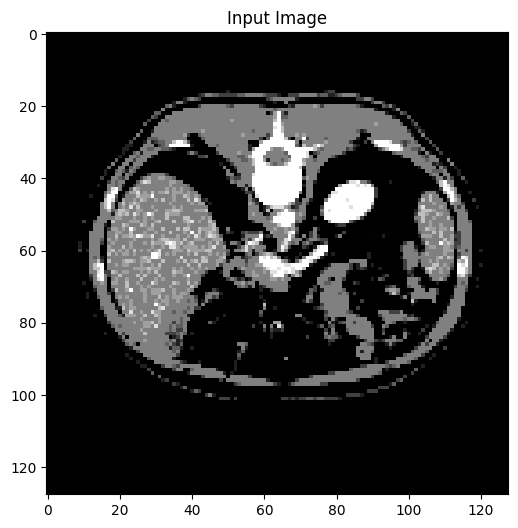

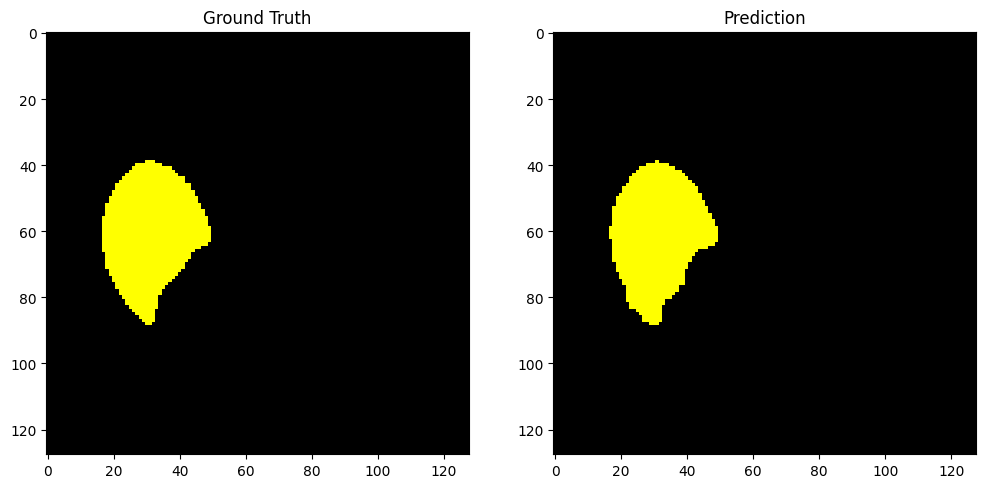

In [33]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth"
visualize_results(model, val_loader, weight_path, num_images, device)